In [1]:
import gizeh as gz
import json
import numpy as np
import pandas as pd
import seaborn as sns
import glob
from itertools import cycle
from more_itertools.recipes import grouper, pairwise
from PIL import Image

import tensorflow as tf
import torch
from pytorch_tabnet.tab_model import TabNetClassifier
from tensorflow.keras.losses import CategoricalCrossentropy

from sklearn import svm
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve,auc, f1_score, accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

%matplotlib inline

np.random.seed(0)
print("Jupyter online")

Jupyter online


In [13]:
def open_json(jsonfile):
    jsonopen = open(jsonfile)
    jfile = json.load(jsonopen)
    jsonopen.close()
    x = pd.DataFrame(jfile)
    return x

def framenames(path, fps):
    frames = np.arange(0, 900*fps+1, 24).tolist()
    startname = 'frame'
    endname = '_keypoints.json'
    frames = frames[1:]
    framelist = []
    for i in frames:
        framelist.append(path+startname+str(i-1)+endname)
        framelist.append(path+startname+str(i)+endname)
        framelist.append(path+startname+str(i+1)+endname)
    return(framelist)

def data_loader(framelist):
    pose1= []
    pose2= []
    count1 = 0
    count2 = 0
    count3 = 0
    count4 = 0
    count5 = 0
    for jsonfile in framelist:
        data = open_json(jsonfile)
        if len(data.index) == 2:
            s1 = data.iloc[0,:]
            s2 = data.iloc[1,:]
            count1 += 1
        if len(data.index) == 3:
            s1 = data.iloc[0,:]
            s2 = data.iloc[2,:]
            count2 += 1
        if len(data.index) == 1:
            s1 = data.iloc[0,:]
            s2 = data.iloc[1,:]
            count3 += 1
        if len(data.index) == 4:        #NEEDS WORK, KN5 frame 216 has 4 skeletons in it
            s1 = data.iloc[0,:]
            s2 = data.iloc[1,:]
            count4 += 1
        if len(data.index) == 5:
            s1 = data.iloc[0,:]
            s2 = data.iloc[1,:]
            count5 += 1

        sig1 = s1["people"]
        sig2 = s2["people"]

        signer1poses = pd.DataFrame.from_dict(sig1, orient='index')
        signer2poses = pd.DataFrame.from_dict(sig2, orient='index')

        signer1 = signer1poses.iloc[1:5,:]
        signer2 = signer2poses.iloc[1:5,:]

        signer1 = signer1.drop(["face_keypoints_2d"])
        signer2 = signer2.drop(["face_keypoints_2d"])
        
        pose1.append(signer1)
        pose2.append(signer2)
    poses = pose1 + pose2
    print('There are '+str(count3)+' frames with 1 person in them')
    print('There are '+str(count1)+' frames with 2 persons in them')
    print('There are '+str(count2)+' frames with 3 persons in them')
    print('There are '+str(count4)+' frames with 4 persons in them')
    print('There are '+str(count5)+' frames with 5 persons in them')
    print()
    print('There are a total of '+str(len(framelist))+" frames")
    return poses

def scale(lst):                                 #Look into standardscaler from sklearn
    newdata = []
    for i,d in enumerate(lst):
        if d.any() > 0:
           newdata.append(d/500)
        else:
            newdata.append(d)
    return newdata


#def scale(lst):
#    scaler = StandardScaler()
#    newdata = scaler.fit_transform(lst)
#    return newdata

def normalizer(lst,nmbr):
    fin = []
    norm = (nmbr*1.8)
    #assuming person 2 always sits on the right in the frame which gives him/her different y coordinates but similar x coordinates.
    z = np.array([norm,0])
    #normalize the y coordinate appropriately for person 1 so relative distances stay the same. 
    for i,d in enumerate(lst):
        if d.any() > 0:
            d = d-z
            fin.append(d)
        else:
            fin.append(d) 
    return fin

def pose_processor(poses):                                                      #Finish pose processor
    poses = poses
    lengthp = len(poses)
    middle = lengthp/2
    p1 = poses[:int(middle)]
    p2 = poses[int(middle):]

    #Create confidenceintervals index
    confidenceintervals = np.arange(-1, 75, 3).tolist()
    confidenceintervals = confidenceintervals[1:]
    #print(confidenceintervals)

    #Create x and y coordinates index
    coordinates = np.arange(0, 75, 1).tolist()
    cs1 = set(confidenceintervals)
    coorindex = [x for x in coordinates if x not in cs1]
    #print(coorindex)

    person1 = []
    for framepose in p1:
        signer1 = pd.DataFrame(framepose) 
        skel1 = signer1.iloc[0,:]
        #Get confidence intervals for signer 1 and 2 per keypoint
        ci1 = [skel1[i] for i in confidenceintervals]
        #Get x and y coordinates for signer 1 and 2 per keypoint
        skelcoor1 = [skel1[i] for i in coorindex]
        sk1 = np.array_split(skelcoor1, 25)
        #Normalize on neck Y coordinate as neck position
        neck2 = sk1[1]
        newdata1 = sk1
        #newdata1 = scale(normalizer(sk1, neck2[0]))
        person1.append(newdata1)
        
    person2 = []
    for framepose in p2:
        signer2 = pd.DataFrame(framepose) 
        skel2 = signer2.iloc[0,:]
        #Get confidence intervals for signer 1 and 2 per keypoint
        ci2 = [skel2[i] for i in confidenceintervals]
        #Get x and y coordinates for signer 1 and 2 per keypoint
        skelcoor2 = [skel2[i] for i in coorindex]
        sk2 = np.array_split(skelcoor2, 25)
        newdata2 = sk2
        #newdata2 = scale(sk2)
        person2.append(newdata2)
    #return sk1, sk2
    signers = person1 + person2
    return signers

def label_loader(labelspath):
    data = pd.read_csv(labelspath)
    data2 = data.iloc[:,3]
    labels = data2
    labels = np.array(labels)
    return labels

def frame_concat(poses):                                                      #Finish pose processor
    poses = poses
    lengthp = len(poses)
    middle = lengthp/2
    p1 = poses[:int(middle)]
    p2 = poses[int(middle):]
    p1 = pd.DataFrame(p1)
    p2 = pd.DataFrame(p2)
    N = 3   
    #Thanks to Ted Manders for helping me with this nice loop, thank you bro
    new_df1 = []
    new_df2 = []
    # For every 3 rows
    for i in range(0, len(p1), 3):
       
        new_row1 = []
        subset1 = p1.iloc[[i, i+1, i+2]]
        # For every column
        for j in subset1:
            new_row1.append(subset1[j].tolist())
        new_row1 = np.array(new_row1)
        new_row1 = new_row1.flatten()
        new_df1.append(new_row1)

        new_row2 = []
        subset2 = p2.iloc[[i, i+1, i+2]]
        # For every column
        for j in subset2:
            new_row2.append(subset2[j].tolist())
        new_row2= np.array(new_row2)
        new_row2 = new_row2.flatten()
        new_df2.append(new_row2)  
    def_df1 = pd.DataFrame(new_df1)
    def_df2 = pd.DataFrame(new_df2)
    dataset = pd.concat([def_df1, def_df2], axis=1)

    #Normalize data squared min-max
    features_min = np.array(dataset).min()
    features_max = np.array(dataset).max()
    features = ((dataset - features_min) / (features_max - features_min))**2
    
    X = features.to_numpy()
    return X

def show_roc_plot(y_true, y_pred, i):
    fold = str(i)
    n_classes = 4
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    lw = 2
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(10,10))
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue", "red"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Some extension of Receiver operating characteristic to multiclass")
    plt.legend(loc="lower right")
    #plt.savefig('ROC'+fold+'.png', bbox_inches='tight')
    plt.show()

def show_accuracy(clf_trainacc, clf_validacc):
    plt.figure(figsize=(10,10))
    plt.plot(clf_trainacc[5:])
    plt.plot(clf_validacc[5:])
    plt.show()

def featureplot(featureslist):
    # Creating a bar plot
    plt.figure(figsize=(25,10))

    sns.barplot(x=featureslist.index, y=featureslist)
    #Add labels to your graph
    plt.ylabel('Feature Importance Score')
    plt.xlabel('Features')
    plt.title("Visualizing Important Features")
    plt.legend()
    plt.show()


def svmfeatureplot(cv_results):
    plt.figure(figsize=(16,6))
    plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_f1_weighted"])
    plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_f1_weighted"])
    plt.xlabel("number of features")
    plt.ylabel("weighted f1 score")
    plt.title("Optimal Number of Features")
    plt.legend(["test score", "train score"], loc="upper left")
    plt.show()


#https://stackoverflow.com/questions/41592661/determining-the-most-contributing-features-for-svm-classifier-in-sklearn
def svmfeatureimportance(svmcoef, feature_names):
    if len(feature_names) != len(abs(svmcoef[0])):
        print(svmcoef)
        #print(x.nlargest(10).plot(kind='barh'))
    else:
        pd.Series(abs(svmcoef[0]), index=feature_names).nlargest(10).plot(kind='barh')

def svmrbfplot(perm_importance,feature_names):
    features = np.array(feature_names)
    sorted_idx = perm_importance.importances_mean.argsort()
    plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
    plt.xlabel("Permutation Importance")
    plt.show()

def finish_processing(path,fps,labelspath):
    framelist = framenames(path, fps)
    poses = data_loader(framelist)
    processedsk = pose_processor(poses)
    framedev = frame_concat(processedsk)
    #features = processedsk
    #labels = label_loader(labelspath)
    return framedev

In [3]:
path = 'D:\Videos thesis\KN5Jan7_poses\KN5Jan7_poses\\'         #Find and explain which features are important for signer diarization/ Turn taking problem as two classes.
fps = 24
labelspath = 'D:\Videos thesis\KN5jan7_annotated.csv'
z = finish_processing(path,fps,labelspath)

There are 0 frames with 1 person in them
There are 2426 frames with 2 persons in them
There are 271 frames with 3 persons in them
There are 3 frames with 4 persons in them
There are 0 frames with 5 persons in them

There are a total of 2700 frames


RangeIndex(start=0, stop=300, step=1)
Fold: # 1
Best Params RFC: {'max_depth': 90, 'max_features': 'sqrt'}
Weighted F1 score RFC: 0.4368365449628127
Accuracy RFC: 0.48333333333333334
Confusion matrix RFC:
[[ 7 10  3  1]
 [ 0 65  8  6]
 [ 1 26 12  6]
 [ 0 28  4  3]]
Classification Report RFC:
              precision    recall  f1-score   support

           0       0.88      0.33      0.48        21
           1       0.50      0.82      0.63        79
           2       0.44      0.27      0.33        45
           3       0.19      0.09      0.12        35

    accuracy                           0.48       180
   macro avg       0.50      0.38      0.39       180
weighted avg       0.47      0.48      0.44       180



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


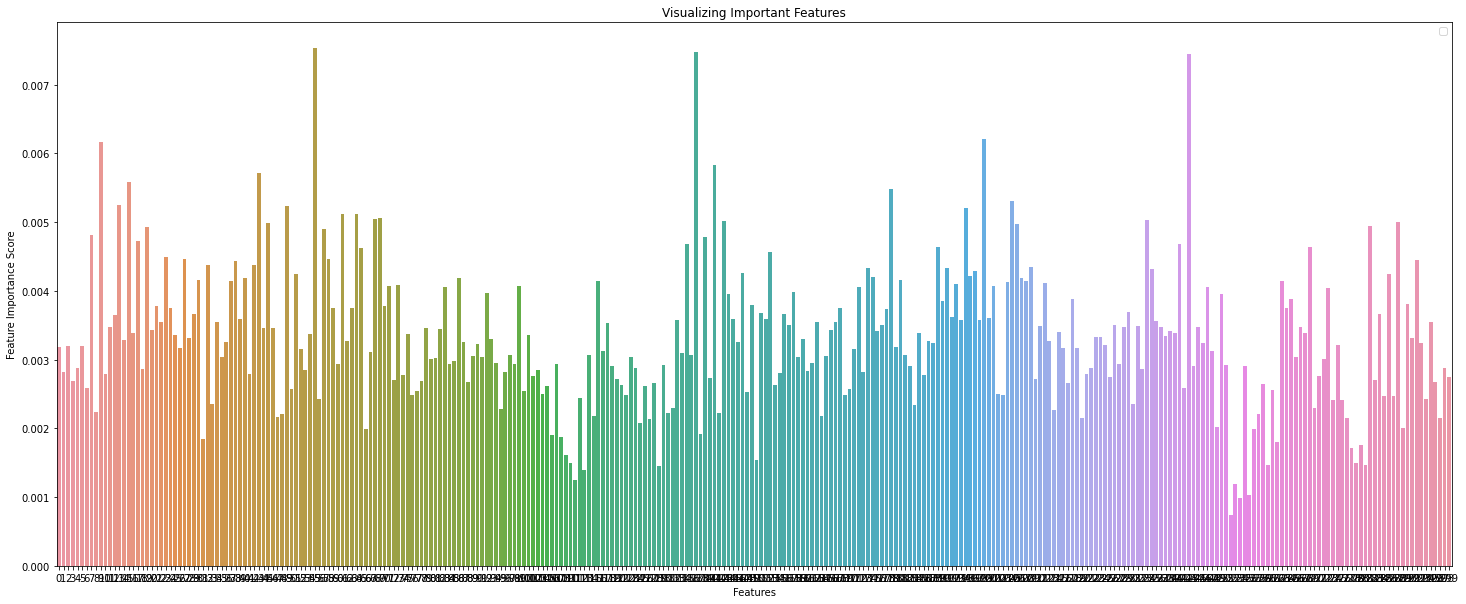

Best Params ADBC: {'learning_rate': 1, 'n_estimators': 5}
Weighted F1 score ADBC: 0.4710899751597056
Accuracy ADBC: 0.5222222222222223
Confusion matrix ADBC:
[[ 9  9  2  1]
 [ 0 70  6  3]
 [ 1 28 10  6]
 [ 0 26  4  5]]
Classification Report ADBC:
              precision    recall  f1-score   support

           0       0.90      0.43      0.58        21
           1       0.53      0.89      0.66        79
           2       0.45      0.22      0.30        45
           3       0.33      0.14      0.20        35

    accuracy                           0.52       180
   macro avg       0.55      0.42      0.43       180
weighted avg       0.51      0.52      0.47       180



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


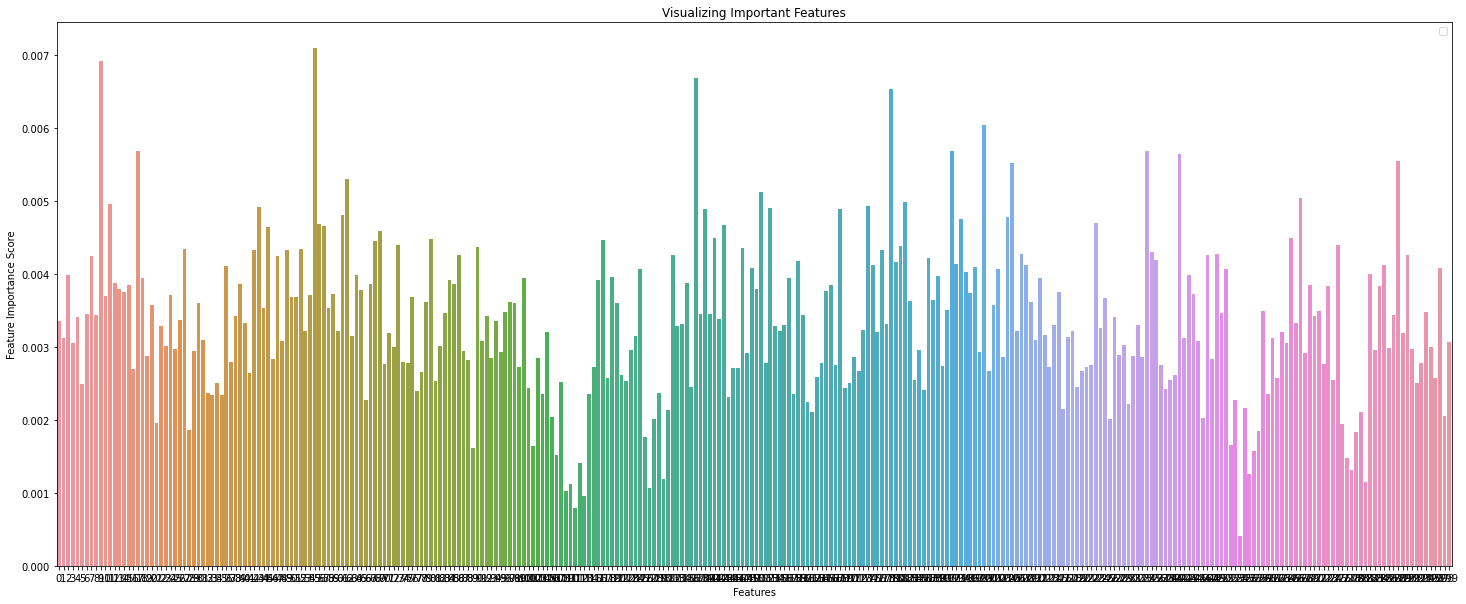

SVM is calculating....


c:\Users\h\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
300 fits failed out of a total of 750.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\h\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\h\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py", line 222, in fit
    return self._fit(X, y, **fit_params)
  File "c:\Users\h\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\fea

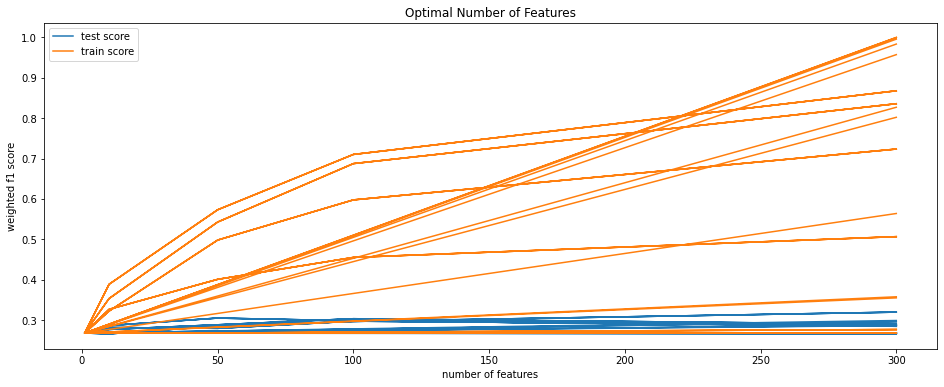

Best Params SVM: {'estimator__C': 10, 'estimator__gamma': 1, 'estimator__kernel': 'linear', 'n_features_to_select': 300}
Weighted F1 score SVM: 0.3977847722945763
Accuracy SVM: 0.43333333333333335
Confusion matrix SVM:
[[ 5  9  3  4]
 [ 3 57 13  6]
 [ 3 29 10  3]
 [ 2 24  3  6]]
Classification Report SVM:
              precision    recall  f1-score   support

           0       0.38      0.24      0.29        21
           1       0.48      0.72      0.58        79
           2       0.34      0.22      0.27        45
           3       0.32      0.17      0.22        35

    accuracy                           0.43       180
   macro avg       0.38      0.34      0.34       180
weighted avg       0.40      0.43      0.40       180

Best Params SVM: {'learning_rate': 0.01}
Weighted F1 score GBC: 0.3837098200279513
Accuracy GBC: 0.4777777777777778
Confusion matrix GBC:
[[ 4 13  4  0]
 [ 0 74  4  1]
 [ 1 36  6  2]
 [ 0 30  3  2]]
Classification Report GBC:
              precision    recal

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


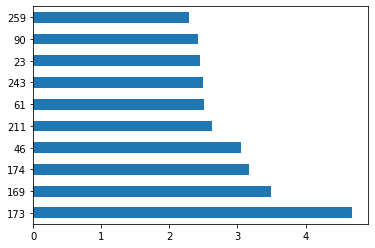

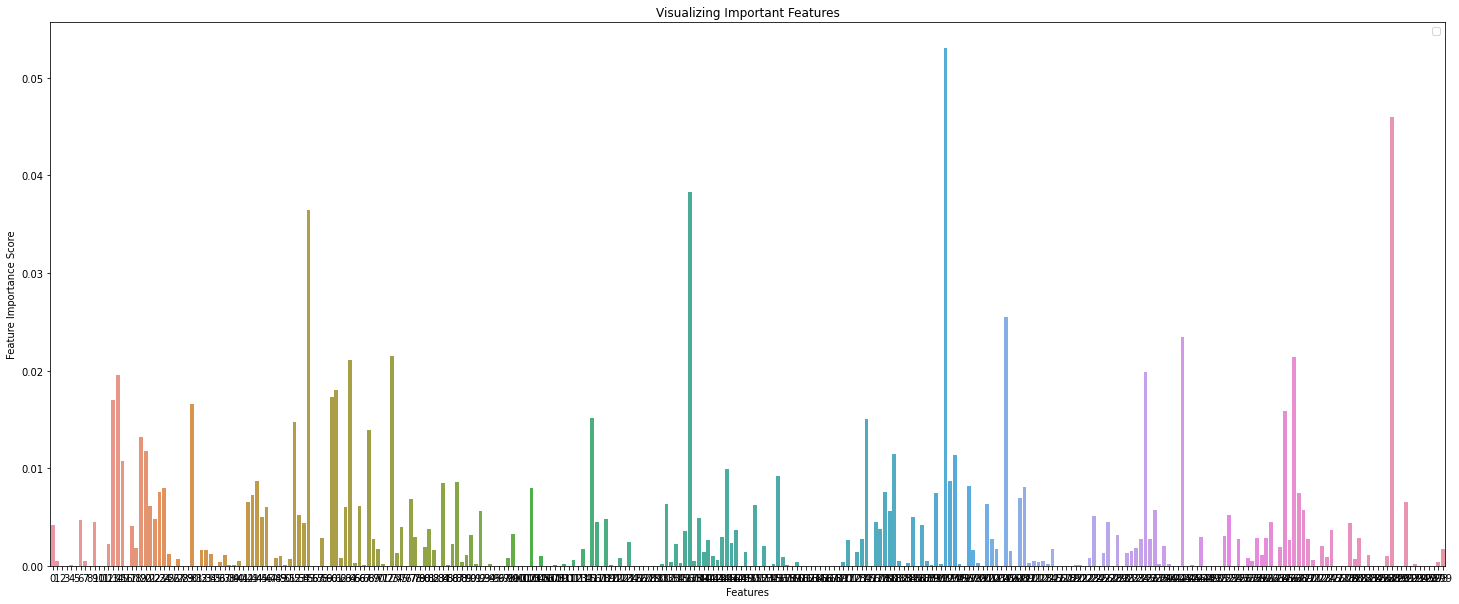


Early stopping occurred at epoch 309 with best_epoch = 9 and best_valid_accuracy = 0.46639
Best weights from best epoch are automatically used!
Weighted F1 score Tabnet: 0.283869174464931

Accuracy Tabnet: 0.43333333333333335

Confusion matrix Tabnet:
[[ 4 13  4  0]
 [ 0 74  4  1]
 [ 1 36  6  2]
 [ 0 30  3  2]]

Classification Report Tabnet:
              precision    recall  f1-score   support

           0       0.80      0.19      0.31        21
           1       0.48      0.94      0.64        79
           2       0.35      0.13      0.19        45
           3       0.40      0.06      0.10        35

    accuracy                           0.48       180
   macro avg       0.51      0.33      0.31       180
weighted avg       0.47      0.48      0.38       180



c:\Users\h\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\h\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\h\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

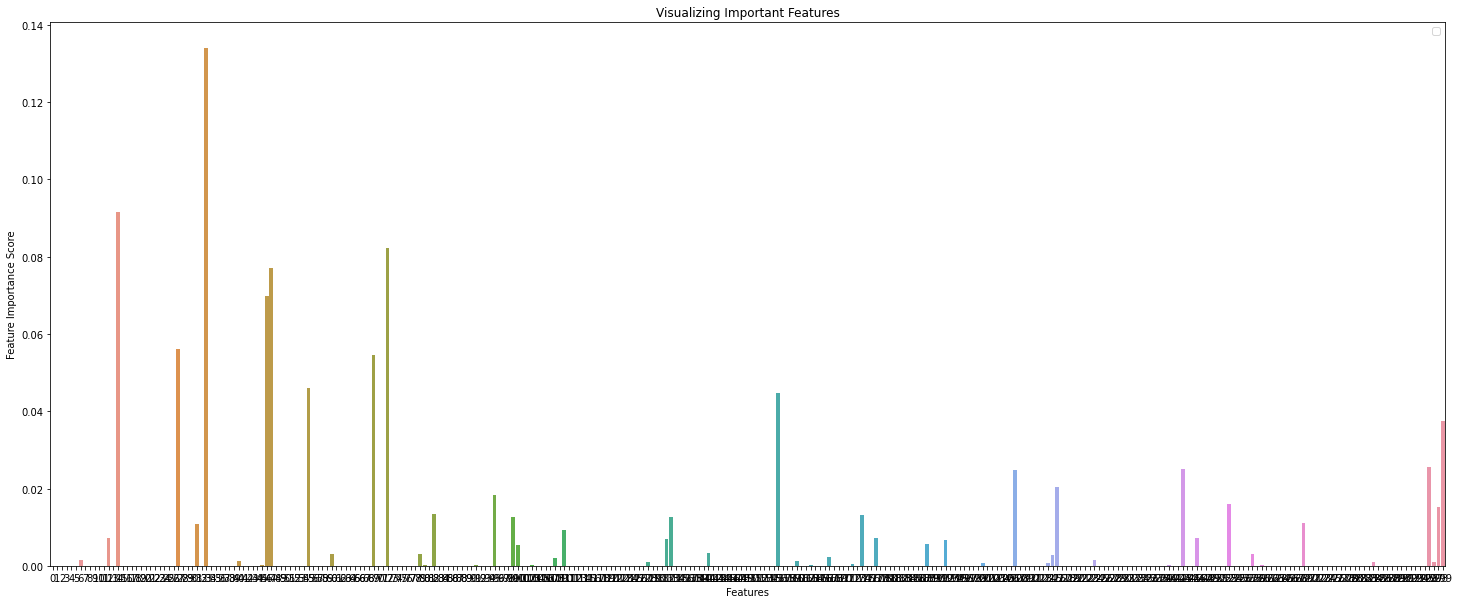

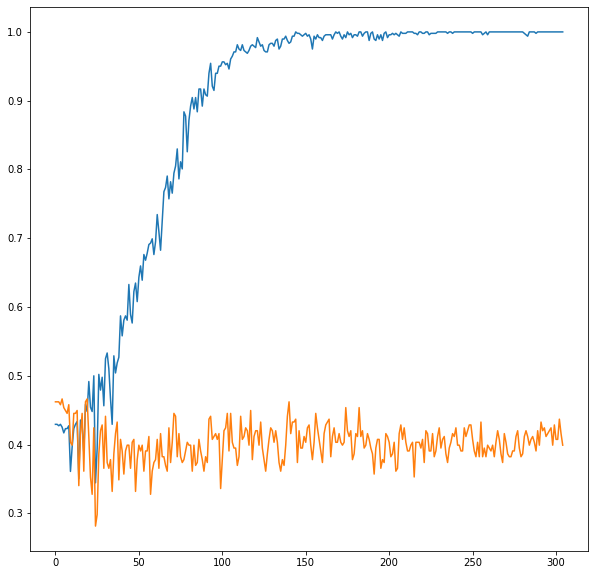

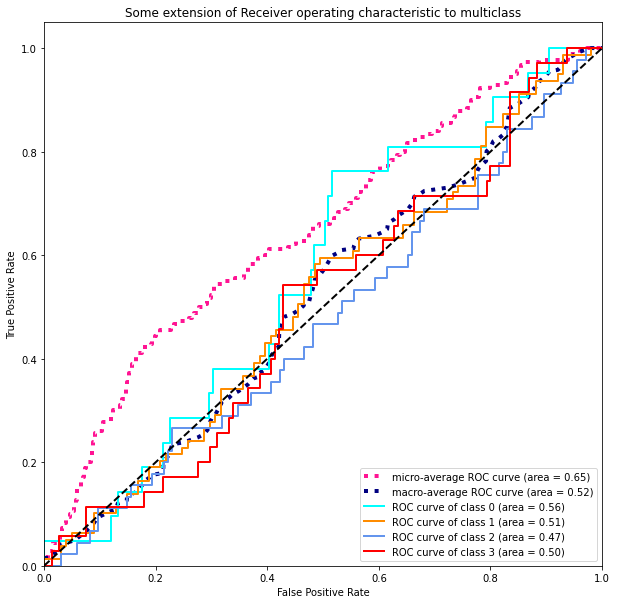

Fold: # 2
Best Params RFC: {'max_depth': None, 'max_features': 'auto'}
Weighted F1 score RFC: 0.5052464765845125
Accuracy RFC: 0.5611111111111111
Confusion matrix RFC:
[[ 6 15  0  0]
 [ 1 73  4  1]
 [ 0 24 18  3]
 [ 0 20 11  4]]
Classification Report RFC:
              precision    recall  f1-score   support

           0       0.86      0.29      0.43        21
           1       0.55      0.92      0.69        79
           2       0.55      0.40      0.46        45
           3       0.50      0.11      0.19        35

    accuracy                           0.56       180
   macro avg       0.61      0.43      0.44       180
weighted avg       0.58      0.56      0.51       180



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


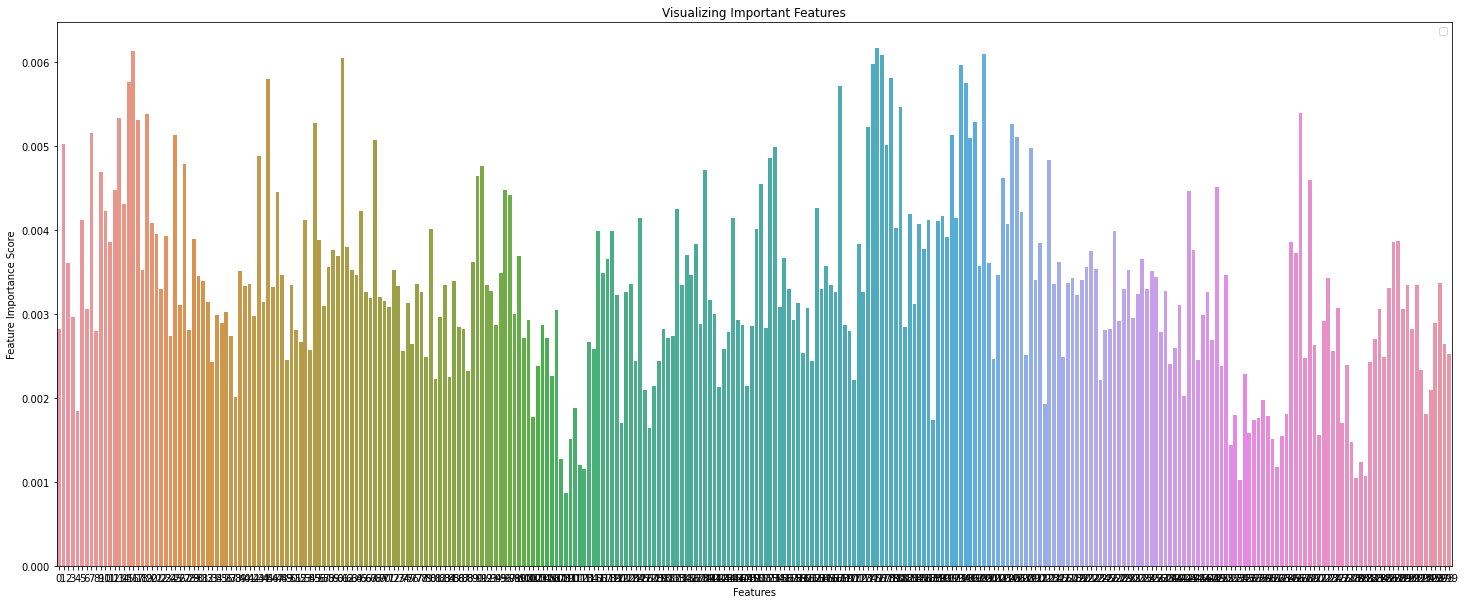

Best Params ADBC: {'learning_rate': 1, 'n_estimators': 5}
Weighted F1 score ADBC: 0.5298090858416946
Accuracy ADBC: 0.5666666666666667
Confusion matrix ADBC:
[[ 7 14  0  0]
 [ 2 69  6  2]
 [ 0 24 19  2]
 [ 0 22  6  7]]
Classification Report ADBC:
              precision    recall  f1-score   support

           0       0.78      0.33      0.47        21
           1       0.53      0.87      0.66        79
           2       0.61      0.42      0.50        45
           3       0.64      0.20      0.30        35

    accuracy                           0.57       180
   macro avg       0.64      0.46      0.48       180
weighted avg       0.60      0.57      0.53       180



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


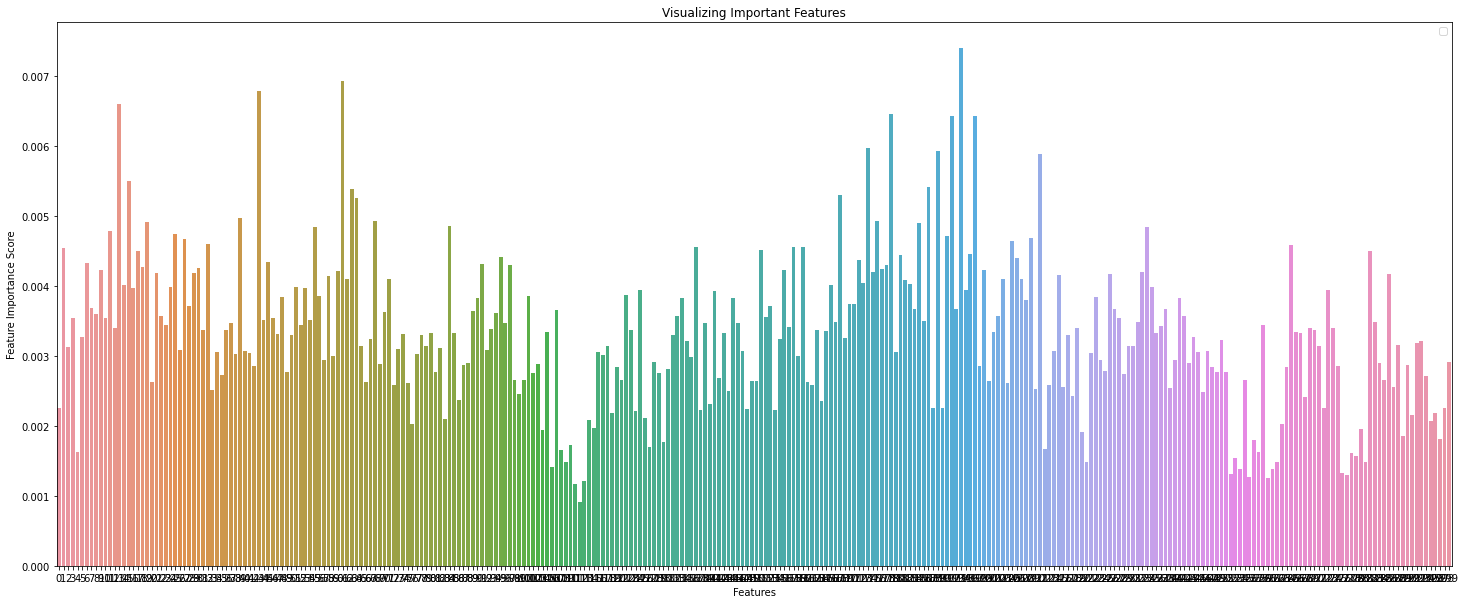

SVM is calculating....


c:\Users\h\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
300 fits failed out of a total of 750.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\h\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\h\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py", line 222, in fit
    return self._fit(X, y, **fit_params)
  File "c:\Users\h\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\fea

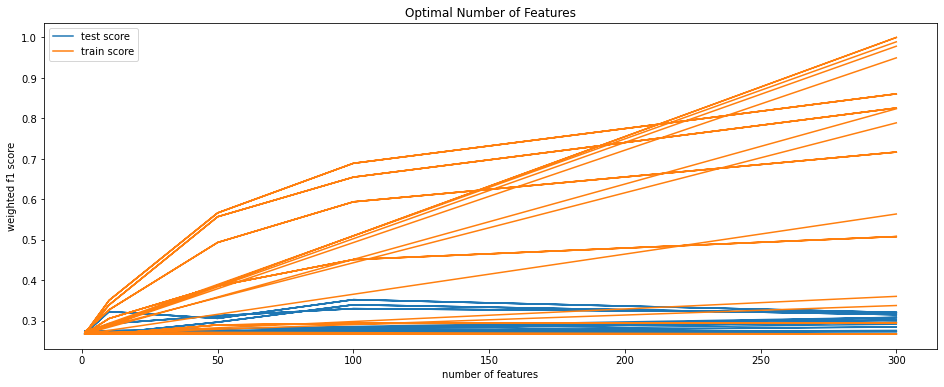

[[ 6.96554724e+00  6.02105627e+00  1.04813929e+00 -3.74600628e+00
  -6.70613482e+00 -2.17194601e-01 -5.26762451e-01 -1.57825126e+00
  -4.42954748e+00 -1.59671663e+00  1.06019146e+01 -6.29539337e+00
   5.55639258e+00  2.58989414e+00  3.13684397e-01  7.11484820e+00
  -2.52441923e+00 -6.66075801e+00 -4.55349756e+00  3.72752970e+00
   8.68766790e+00 -7.33410162e+00 -4.81333395e+00 -1.13251383e+01
  -1.25426670e+01 -7.10860838e+00 -1.22380667e+00 -6.34811970e+00
  -1.10222129e+01 -1.04507491e+01  2.25598059e+00  1.62396903e+00
   5.80598223e+00  6.08913419e+00 -1.06888304e+01 -9.15100194e+00
   8.16907326e-01  3.44855375e+00  2.45984757e+00  1.17784703e+00
   2.96072310e+00 -2.81690722e-01  5.03310622e+00  7.21646566e+00
  -7.48188559e+00  5.65430875e-01 -3.57437779e+00  8.38734212e+00
   8.18828970e+00  5.97077007e-01  4.37836962e+00  5.48783980e+00
  -7.03801737e+00 -2.52103430e+00  2.96016128e+00  5.77454212e+00
   3.04846807e+00  4.54320692e+00 -2.30410756e+00 -2.03683878e+00
  -2.84771

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


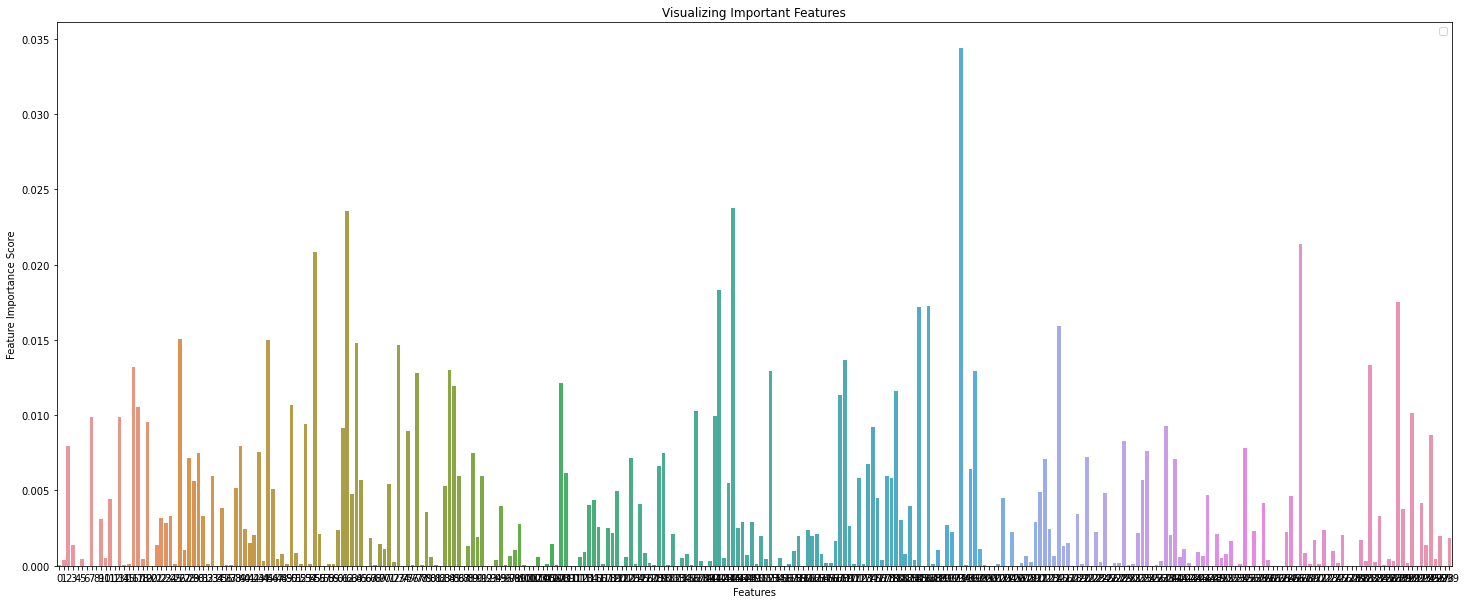


Early stopping occurred at epoch 310 with best_epoch = 10 and best_valid_accuracy = 0.46218
Best weights from best epoch are automatically used!
Weighted F1 score Tabnet: 0.2677391677391677

Accuracy Tabnet: 0.4388888888888889

Confusion matrix Tabnet:
[[ 7 11  2  1]
 [ 5 54 11  9]
 [ 1 14 22  8]
 [ 0 16  9 10]]

Classification Report Tabnet:
              precision    recall  f1-score   support

           0       0.54      0.33      0.41        21
           1       0.57      0.68      0.62        79
           2       0.50      0.49      0.49        45
           3       0.36      0.29      0.32        35

    accuracy                           0.52       180
   macro avg       0.49      0.45      0.46       180
weighted avg       0.51      0.52      0.51       180



c:\Users\h\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\h\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\h\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

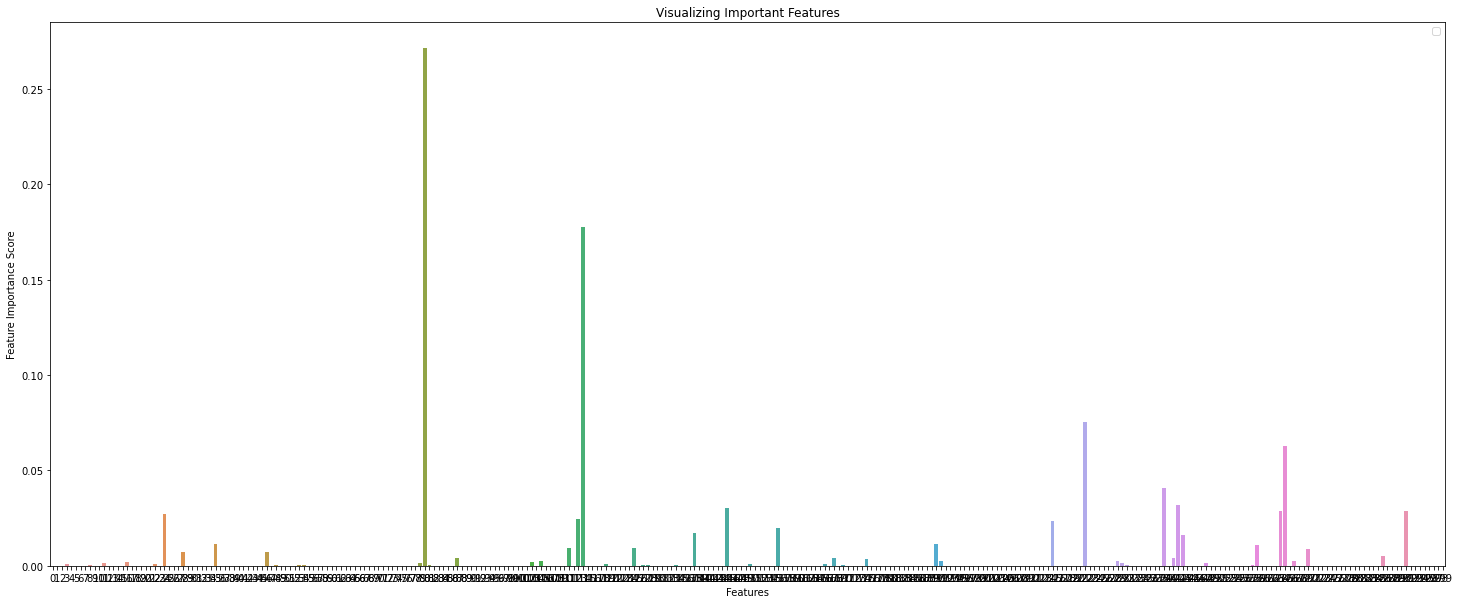

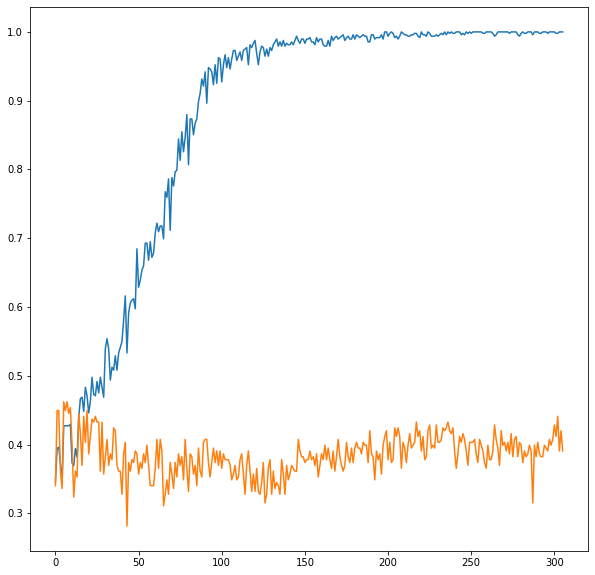

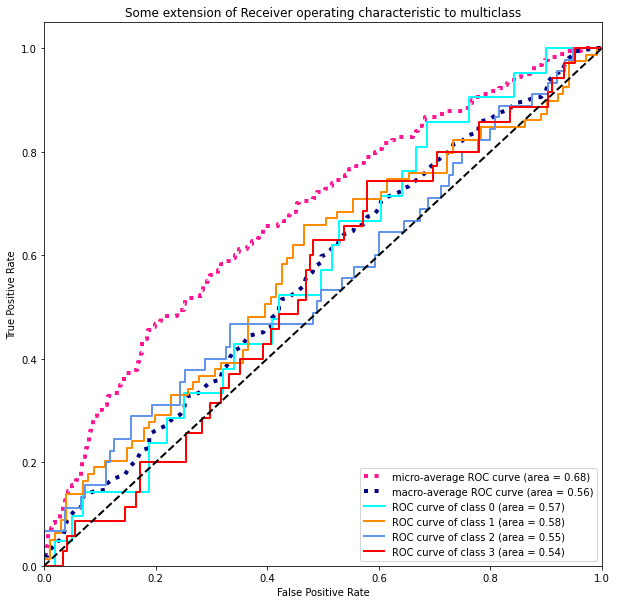

Fold: # 3
Best Params RFC: {'max_depth': 140, 'max_features': 'auto'}
Weighted F1 score RFC: 0.515862691960253
Accuracy RFC: 0.5777777777777777
Confusion matrix RFC:
[[11  9  0  0]
 [ 1 69  6  3]
 [ 1 19 24  1]
 [ 0 29  7  0]]
Classification Report RFC:
              precision    recall  f1-score   support

           0       0.85      0.55      0.67        20
           1       0.55      0.87      0.67        79
           2       0.65      0.53      0.59        45
           3       0.00      0.00      0.00        36

    accuracy                           0.58       180
   macro avg       0.51      0.49      0.48       180
weighted avg       0.50      0.58      0.52       180



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


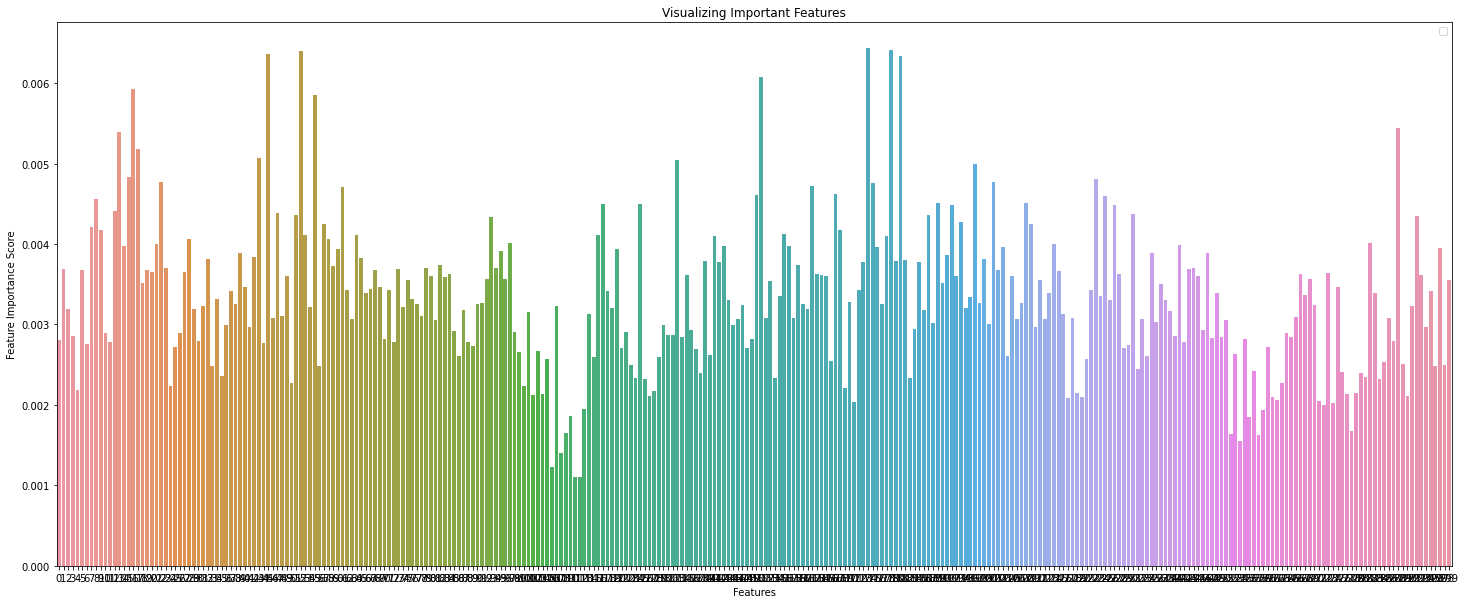

Best Params ADBC: {'learning_rate': 0.001, 'n_estimators': 1}
Weighted F1 score ADBC: 0.5392246642246642
Accuracy ADBC: 0.6
Confusion matrix ADBC:
[[11  7  2  0]
 [ 0 74  3  2]
 [ 1 19 22  3]
 [ 0 29  6  1]]
Classification Report ADBC:
              precision    recall  f1-score   support

           0       0.92      0.55      0.69        20
           1       0.57      0.94      0.71        79
           2       0.67      0.49      0.56        45
           3       0.17      0.03      0.05        36

    accuracy                           0.60       180
   macro avg       0.58      0.50      0.50       180
weighted avg       0.55      0.60      0.54       180



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


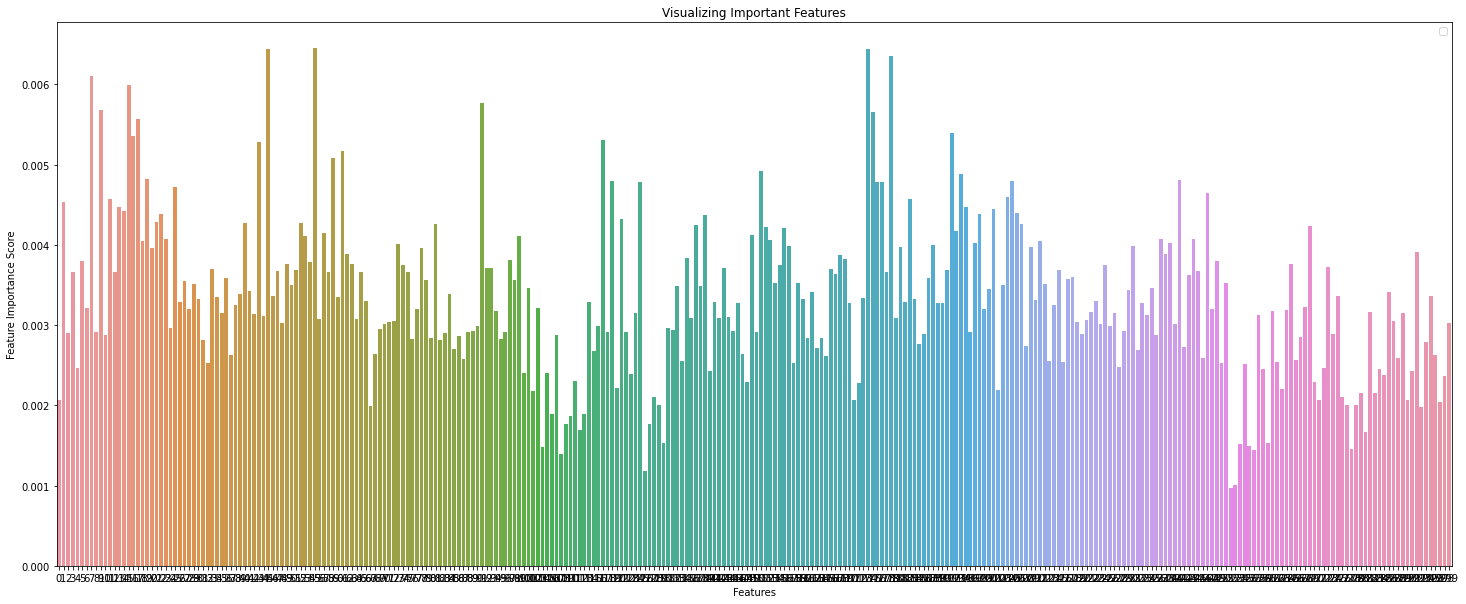

SVM is calculating....


c:\Users\h\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
300 fits failed out of a total of 750.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\h\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\h\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py", line 222, in fit
    return self._fit(X, y, **fit_params)
  File "c:\Users\h\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\fea

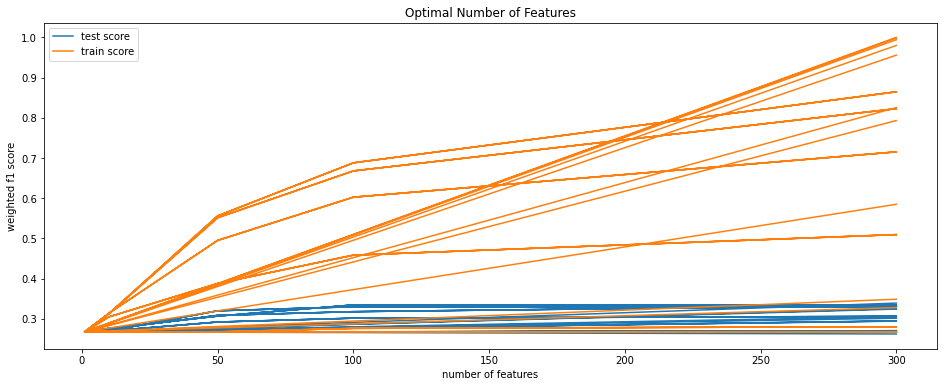

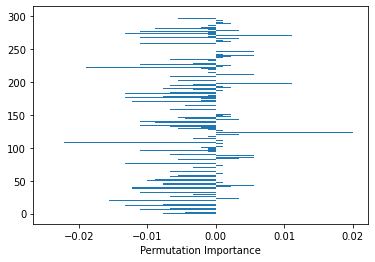

Best Params SVM: {'estimator__C': 10, 'estimator__gamma': 1, 'estimator__kernel': 'rbf', 'n_features_to_select': 300}
Weighted F1 score SVM: 0.3134922111938241
Accuracy SVM: 0.35
Confusion matrix SVM:
[[ 4 14  1  1]
 [ 4 48 14 13]
 [ 3 27 11  4]
 [ 0 27  9  0]]
Classification Report SVM:
              precision    recall  f1-score   support

           0       0.36      0.20      0.26        20
           1       0.41      0.61      0.49        79
           2       0.31      0.24      0.27        45
           3       0.00      0.00      0.00        36

    accuracy                           0.35       180
   macro avg       0.27      0.26      0.26       180
weighted avg       0.30      0.35      0.31       180

Best Params SVM: {'learning_rate': 0.1}
Weighted F1 score GBC: 0.5470157760073727
Accuracy GBC: 0.5833333333333334
Confusion matrix GBC:
[[13  5  0  2]
 [ 0 63  9  7]
 [ 0 16 27  2]
 [ 1 24  9  2]]
Classification Report GBC:
              precision    recall  f1-score   suppo

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


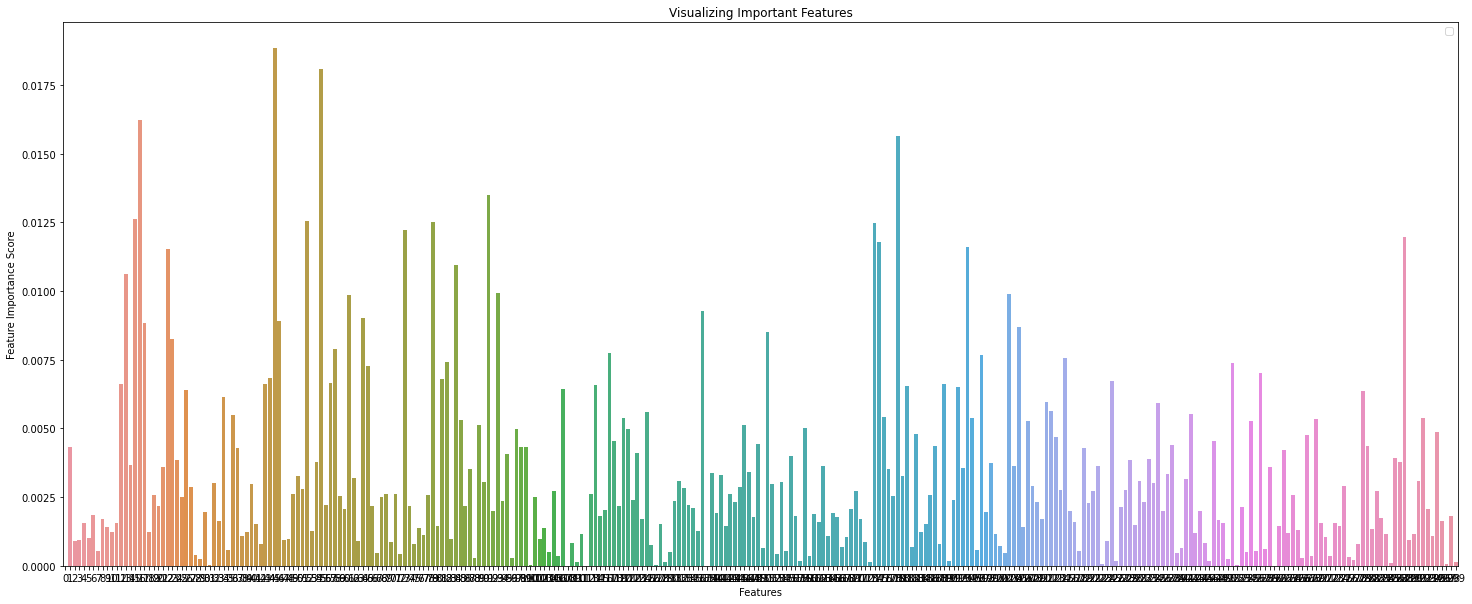


Early stopping occurred at epoch 319 with best_epoch = 19 and best_valid_accuracy = 0.48319
Best weights from best epoch are automatically used!
Weighted F1 score Tabnet: 0.3003555555555555

Accuracy Tabnet: 0.4444444444444444

Confusion matrix Tabnet:
[[13  5  0  2]
 [ 0 63  9  7]
 [ 0 16 27  2]
 [ 1 24  9  2]]

Classification Report Tabnet:
              precision    recall  f1-score   support

           0       0.93      0.65      0.76        20
           1       0.58      0.80      0.67        79
           2       0.60      0.60      0.60        45
           3       0.15      0.06      0.08        36

    accuracy                           0.58       180
   macro avg       0.57      0.53      0.53       180
weighted avg       0.54      0.58      0.55       180



c:\Users\h\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\h\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\h\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

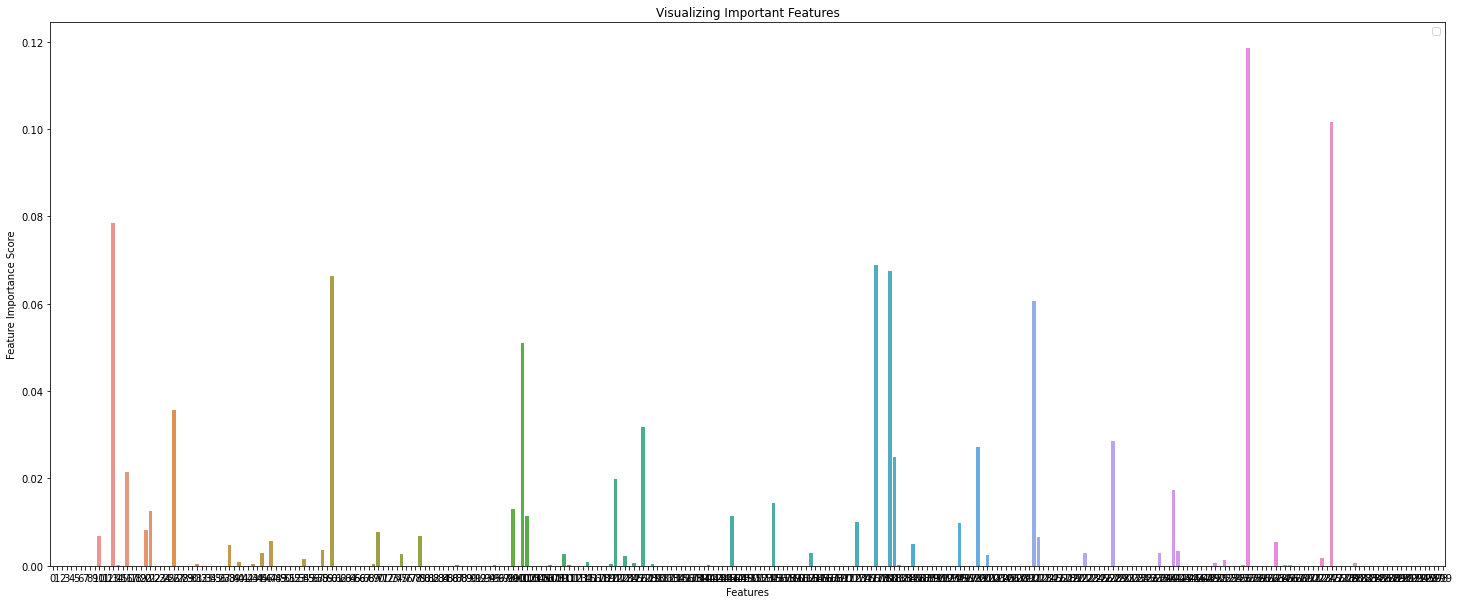

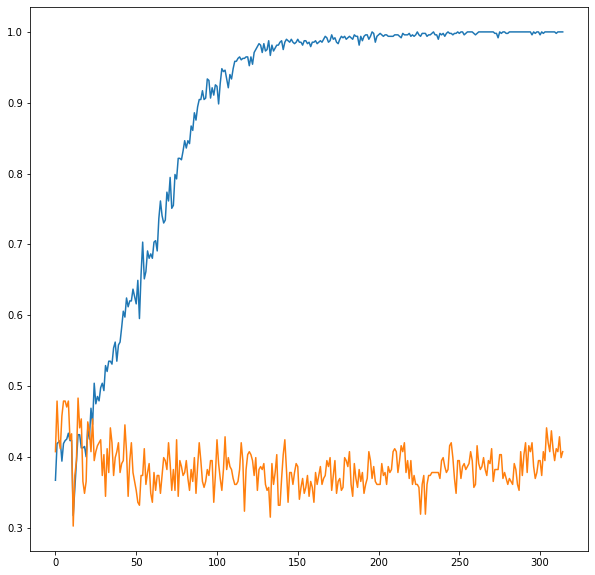

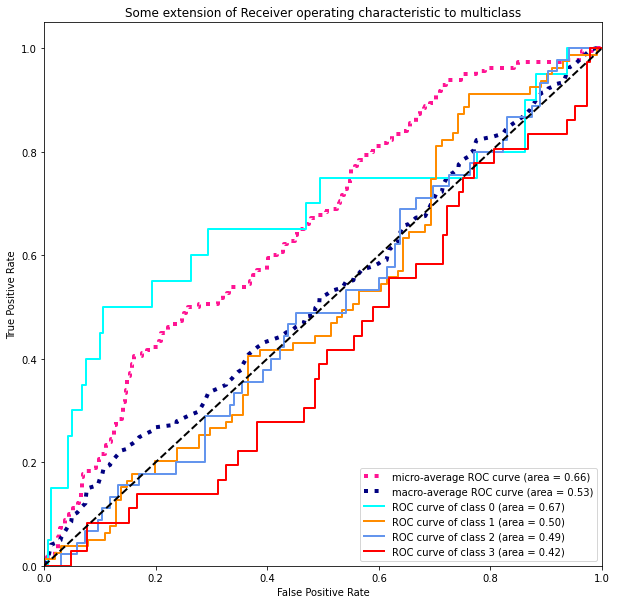

Fold: # 4
Best Params RFC: {'max_depth': 30, 'max_features': 'sqrt'}
Weighted F1 score RFC: 0.4469226314349174
Accuracy RFC: 0.48333333333333334
Confusion matrix RFC:
[[ 9  9  2  0]
 [ 4 60  9  6]
 [ 0 23 15  7]
 [ 1 24  8  3]]
Classification Report RFC:
              precision    recall  f1-score   support

           0       0.64      0.45      0.53        20
           1       0.52      0.76      0.62        79
           2       0.44      0.33      0.38        45
           3       0.19      0.08      0.12        36

    accuracy                           0.48       180
   macro avg       0.45      0.41      0.41       180
weighted avg       0.45      0.48      0.45       180



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


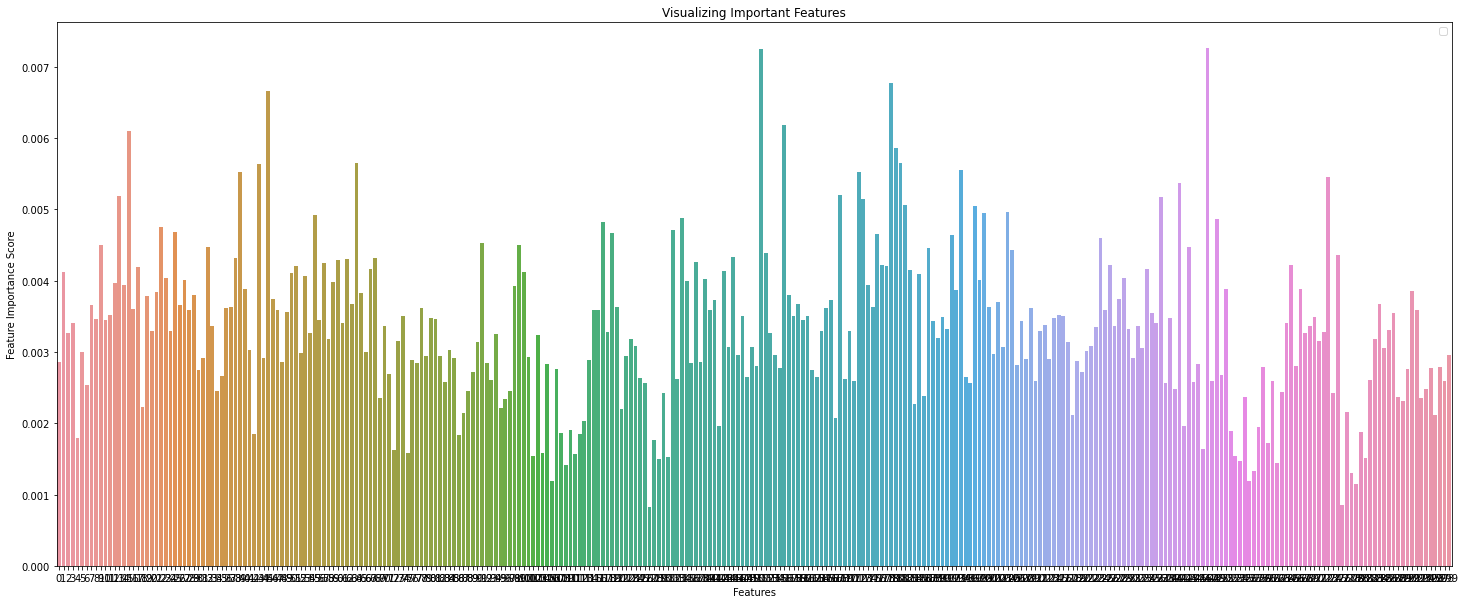

Best Params ADBC: {'learning_rate': 0.01, 'n_estimators': 1}
Weighted F1 score ADBC: 0.4718929900072439
Accuracy ADBC: 0.5222222222222223
Confusion matrix ADBC:
[[10  8  2  0]
 [ 3 65  7  4]
 [ 0 22 18  5]
 [ 1 28  6  1]]
Classification Report ADBC:
              precision    recall  f1-score   support

           0       0.71      0.50      0.59        20
           1       0.53      0.82      0.64        79
           2       0.55      0.40      0.46        45
           3       0.10      0.03      0.04        36

    accuracy                           0.52       180
   macro avg       0.47      0.44      0.43       180
weighted avg       0.47      0.52      0.47       180



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


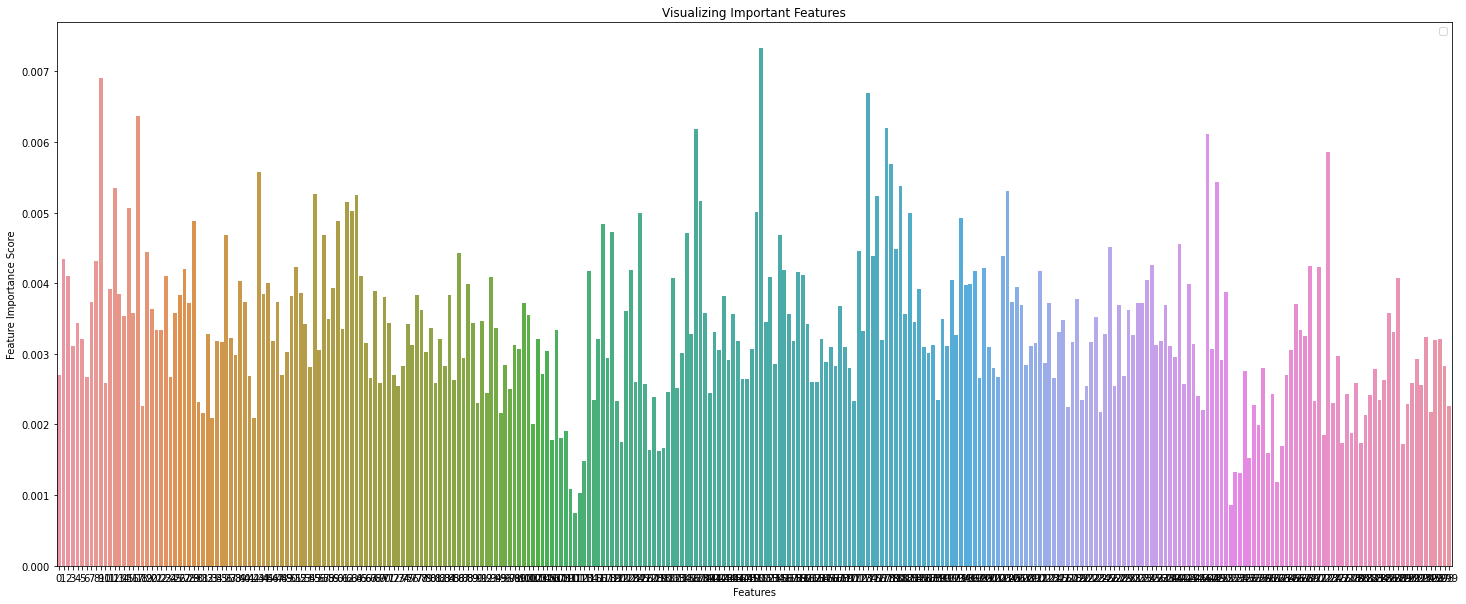

SVM is calculating....


c:\Users\h\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
300 fits failed out of a total of 750.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\h\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\h\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py", line 222, in fit
    return self._fit(X, y, **fit_params)
  File "c:\Users\h\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\fea

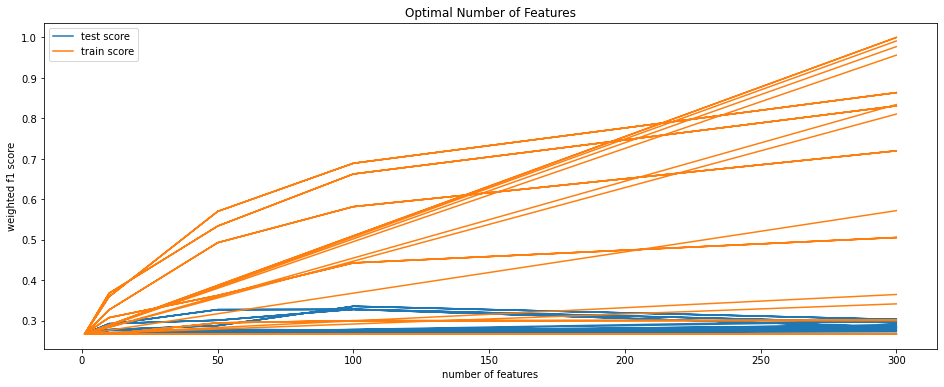

[[ 2.76764192e+00  3.85979246e-01 -2.06785049e-01 -1.64076870e-01
  -2.42257817e-01 -5.34943832e-01 -2.31093556e+00  1.46382490e+00
   2.64631774e+00  1.89326401e+00 -1.71998566e+00 -1.28310917e+00
  -2.70304792e+00 -1.17845755e+00  1.40205250e+00  2.19058259e+00
  -2.08325550e+00 -6.25790929e-01 -1.49278702e+00 -1.06071618e+00
  -5.41142845e-01 -1.40456909e+00 -1.32336884e+00  1.13499832e-01
  -3.12821842e-01 -8.31515792e-01 -1.72314565e+00 -4.17733383e-01
  -1.73925867e+00  1.68376271e+00  2.54687094e+00 -1.13496080e+00
   1.23503665e+00  5.72911501e-02  1.33555661e+00  3.99926246e+00
  -2.17445861e+00 -2.89806869e+00  2.25684550e+00  1.65391280e+00
   2.32873151e+00 -8.50875787e-01 -6.17051126e-01  2.17443861e+00
  -1.53251739e+00  3.19056792e+00  1.62135563e+00 -2.14631978e+00
   2.31025188e+00 -8.17508421e-04 -1.48964413e+00 -1.75284339e+00
  -5.82208568e-01  2.01738260e+00  1.57729403e+00  9.25965583e-01
   1.89243441e+00 -3.62565434e-01  1.51799178e+00  1.31212550e+00
  -1.98357

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


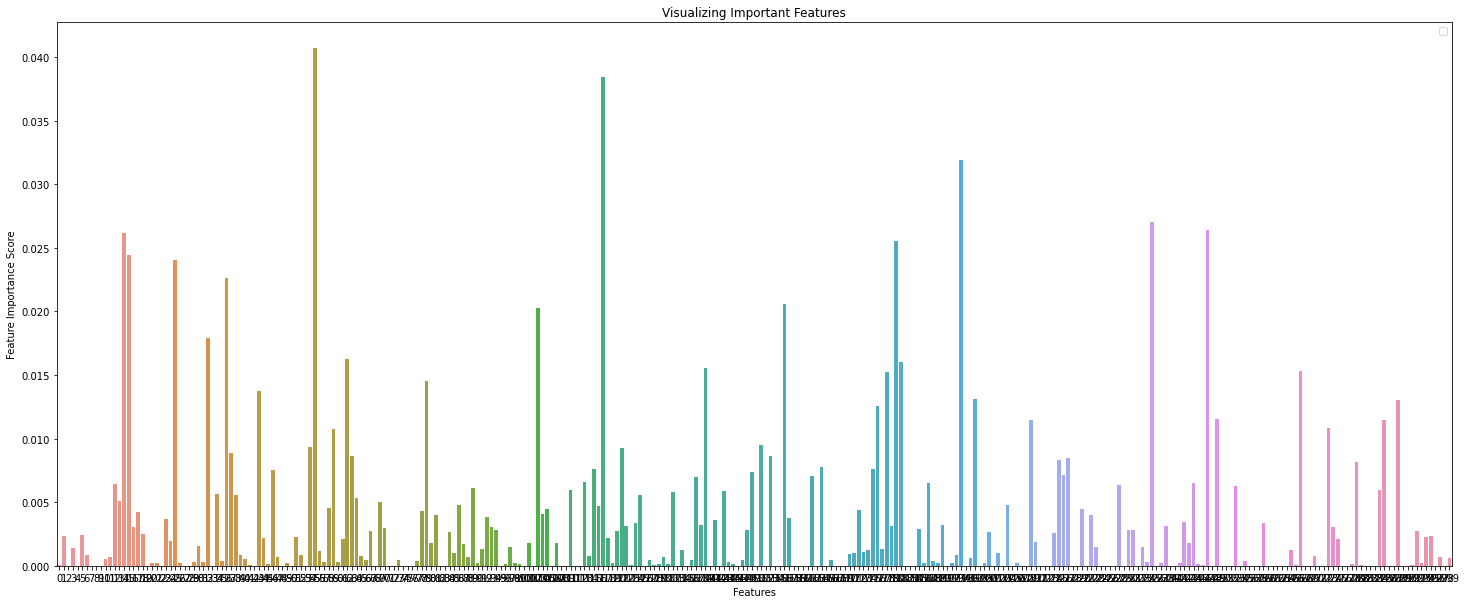


Early stopping occurred at epoch 320 with best_epoch = 20 and best_valid_accuracy = 0.46218
Best weights from best epoch are automatically used!
Weighted F1 score Tabnet: 0.3473684210526316

Accuracy Tabnet: 0.4777777777777778

Confusion matrix Tabnet:
[[ 4 13  3  0]
 [ 1 70  7  1]
 [ 0 31  7  7]
 [ 1 29  4  2]]

Classification Report Tabnet:
              precision    recall  f1-score   support

           0       0.67      0.20      0.31        20
           1       0.49      0.89      0.63        79
           2       0.33      0.16      0.21        45
           3       0.20      0.06      0.09        36

    accuracy                           0.46       180
   macro avg       0.42      0.32      0.31       180
weighted avg       0.41      0.46      0.38       180



c:\Users\h\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\h\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\h\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

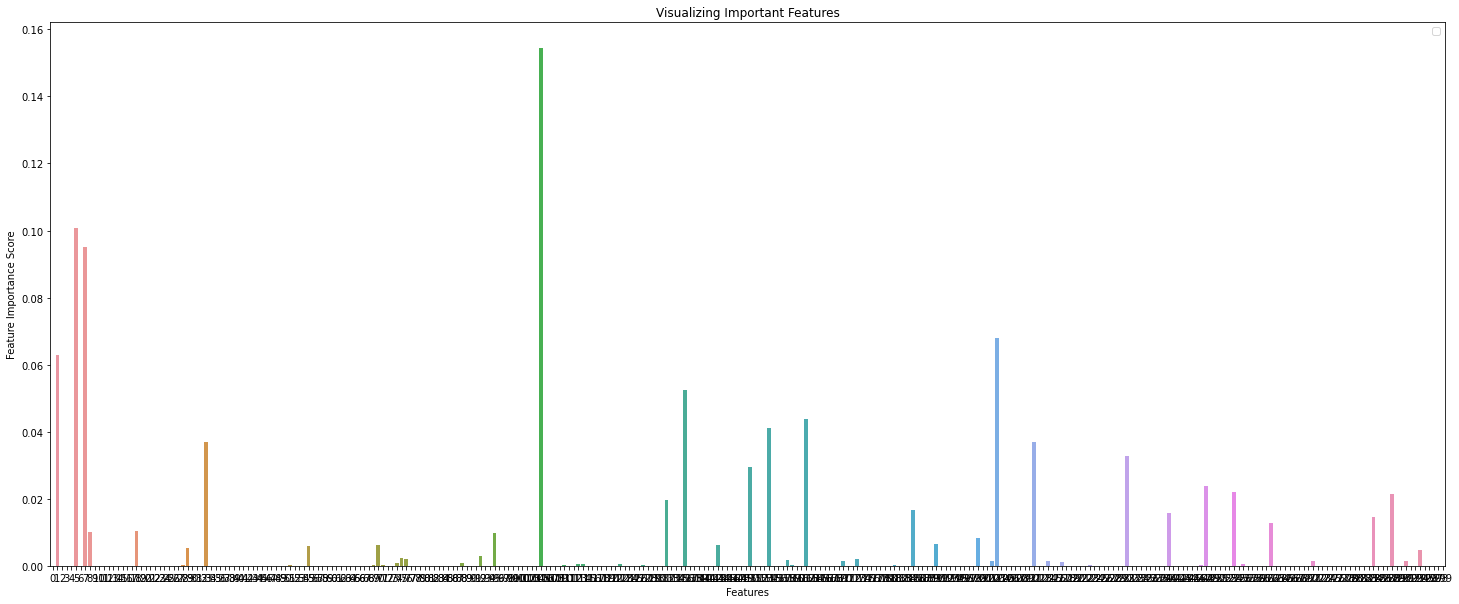

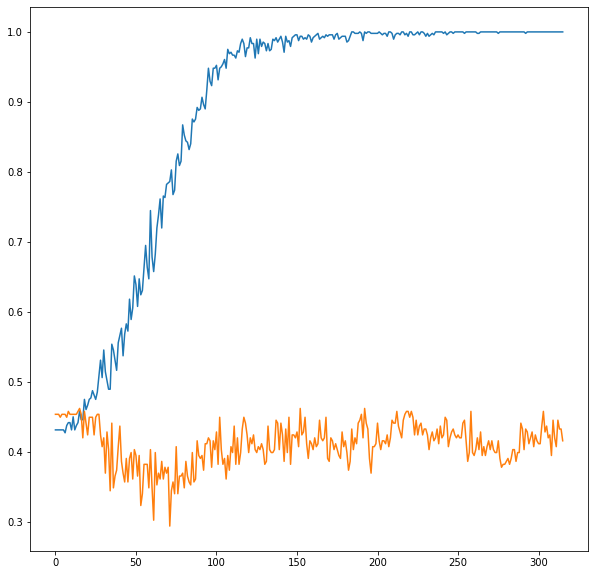

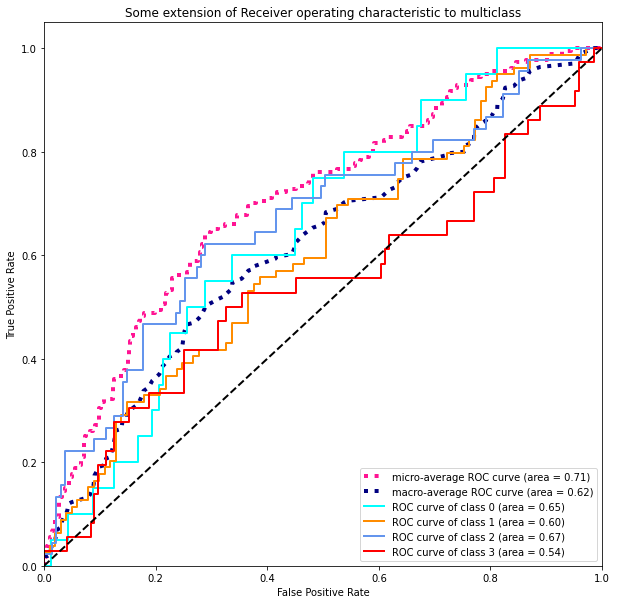

Fold: # 5
Best Params RFC: {'max_depth': 10, 'max_features': 'sqrt'}
Weighted F1 score RFC: 0.44285229674118565
Accuracy RFC: 0.5166666666666667
Confusion matrix RFC:
[[ 3 17  0  0]
 [ 2 71  6  0]
 [ 1 28 17  0]
 [ 1 21 11  2]]
Classification Report RFC:
              precision    recall  f1-score   support

           0       0.43      0.15      0.22        20
           1       0.52      0.90      0.66        79
           2       0.50      0.37      0.42        46
           3       1.00      0.06      0.11        35

    accuracy                           0.52       180
   macro avg       0.61      0.37      0.35       180
weighted avg       0.60      0.52      0.44       180



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


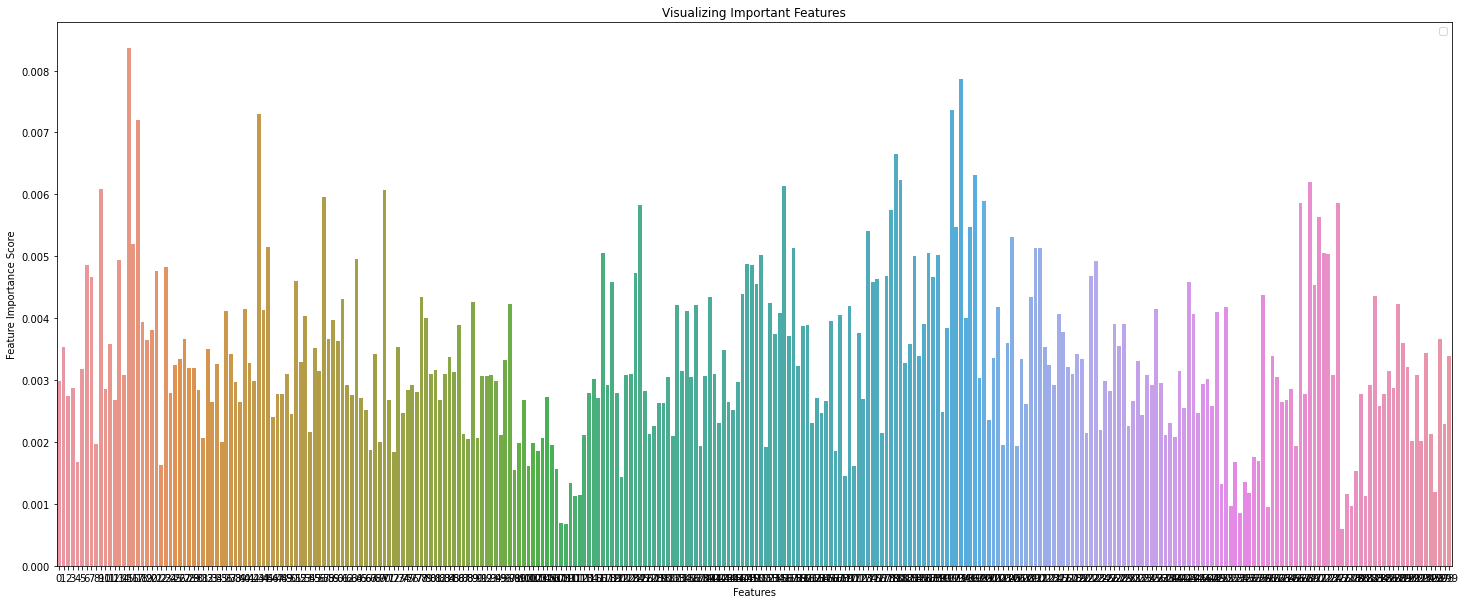

Best Params ADBC: {'learning_rate': 0.01, 'n_estimators': 1}
Weighted F1 score ADBC: 0.4236491225444714
Accuracy ADBC: 0.49444444444444446
Confusion matrix ADBC:
[[ 5 14  1  0]
 [ 2 68  8  1]
 [ 1 30 15  0]
 [ 0 24 10  1]]
Classification Report ADBC:
              precision    recall  f1-score   support

           0       0.62      0.25      0.36        20
           1       0.50      0.86      0.63        79
           2       0.44      0.33      0.38        46
           3       0.50      0.03      0.05        35

    accuracy                           0.49       180
   macro avg       0.52      0.37      0.35       180
weighted avg       0.50      0.49      0.42       180



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


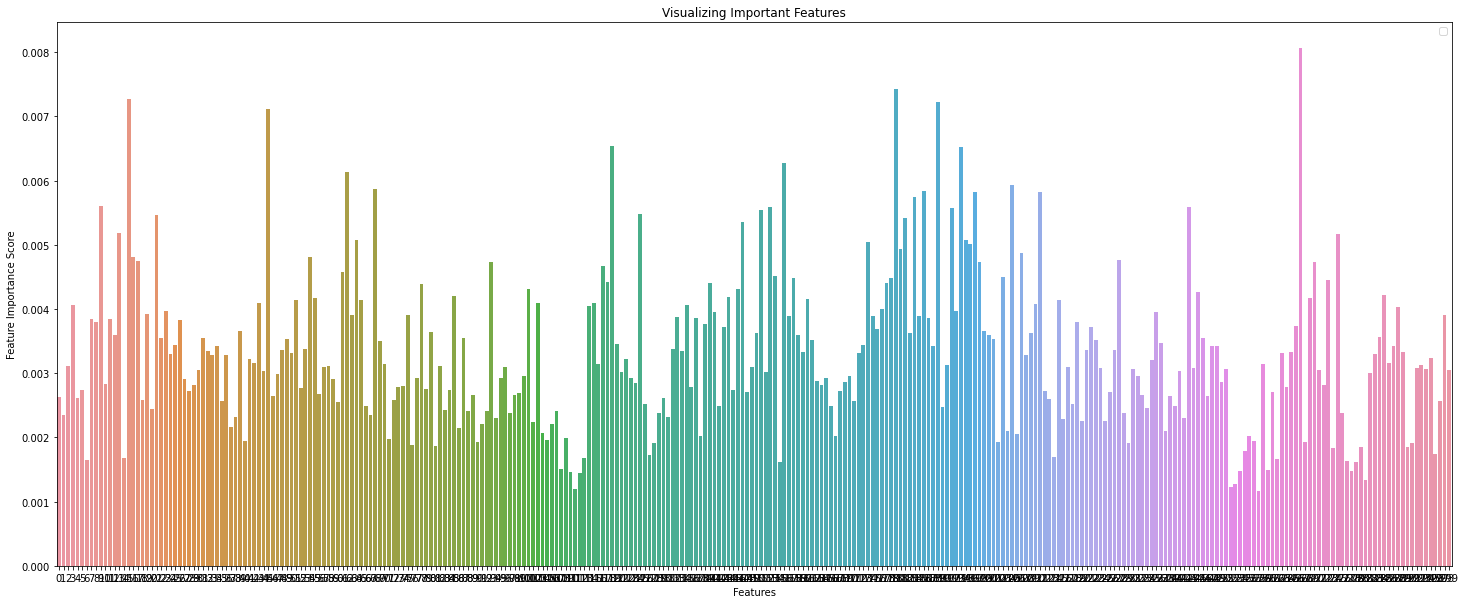

SVM is calculating....


c:\Users\h\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
300 fits failed out of a total of 750.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\h\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\h\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py", line 222, in fit
    return self._fit(X, y, **fit_params)
  File "c:\Users\h\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\fea

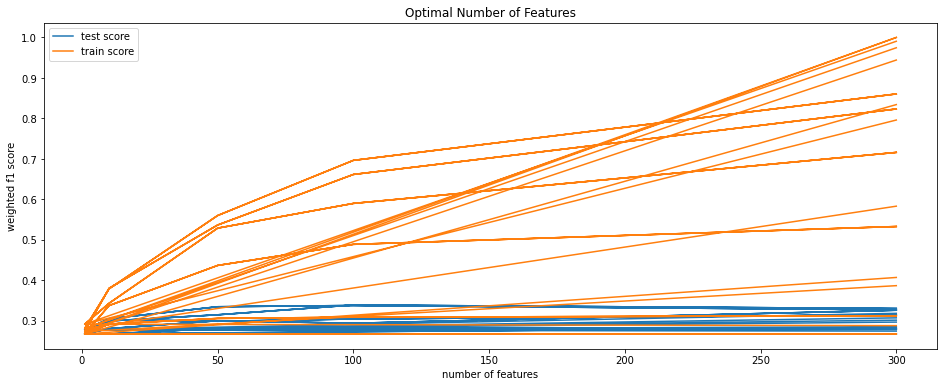

[[ 1.33960654 -0.65653162 -0.67187646 -0.82066383 -0.04140438 -2.14322597
   0.33748012 -2.68615435 -1.26061873  1.57831455  1.8487147   0.21767231
  -2.11895809  2.38251254 -1.75437125 -1.89690197 -0.86876603 -1.2564079
  -2.00024026 -0.52411078 -0.42054904 -0.55439335 -1.09827812  0.05093205
  -0.66123608  1.31437792 -2.51847646  0.31827243  1.22008747 -0.31031438
   1.36860752  2.78410236 -0.50332854  0.99053925  0.24663076  1.42907934
   1.79488231  2.19666712 -1.91172597  2.03678178  0.54052122 -1.30425507
  -3.13960402  0.82285103  0.58714639  1.51422299  0.91207338 -0.49950818
   0.56900467  1.45261808 -1.4339068   3.07836177 -0.83712931 -1.48598805
  -1.40559502 -3.30991572  1.67128907  1.01980318 -0.80650808  1.15697041
  -2.29190585 -1.81305601 -1.37522861 -1.65768176 -0.58934535  0.46861954
  -0.97281179 -3.20081017 -0.54743984  1.22944505 -1.70705537 -1.70723872
   2.10422373  1.44917581  1.04924594  1.45331836  0.02151147  0.45689989
  -1.15371414 -1.03213418 -3.38534214  

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


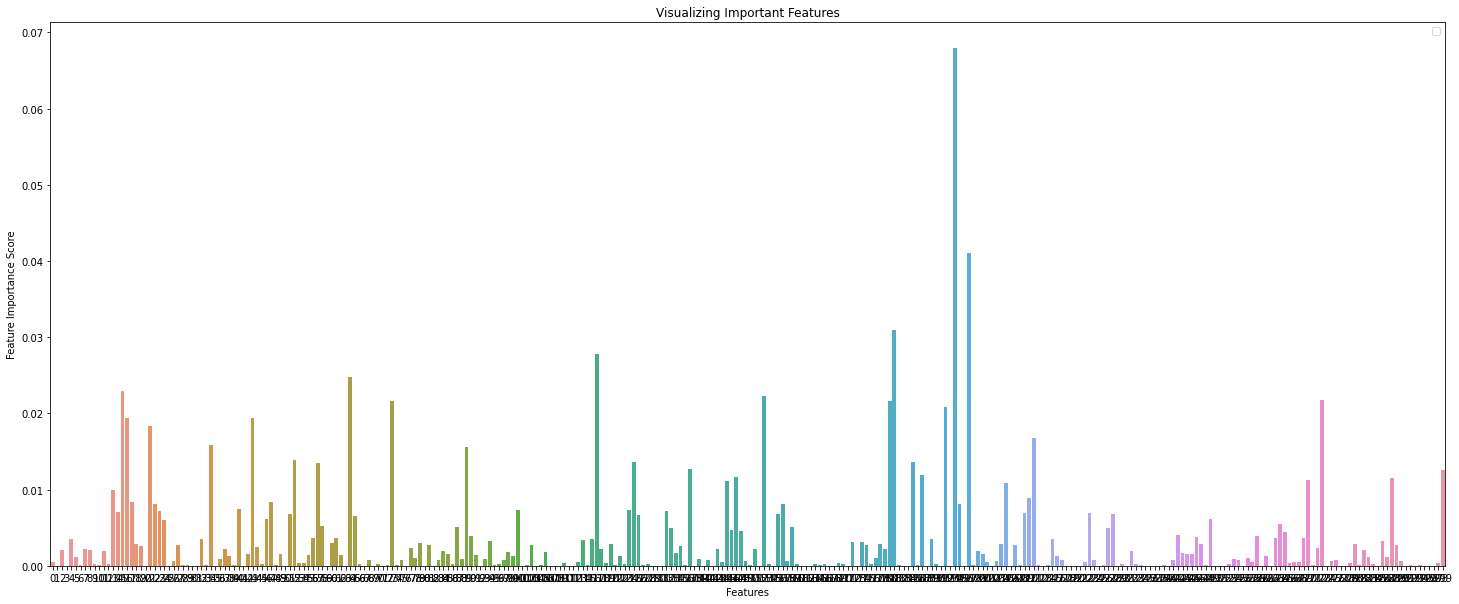


Early stopping occurred at epoch 336 with best_epoch = 36 and best_valid_accuracy = 0.47479
Best weights from best epoch are automatically used!
Weighted F1 score Tabnet: 0.28402329749103944

Accuracy Tabnet: 0.3611111111111111

Confusion matrix Tabnet:
[[ 2 18  0  0]
 [ 0 70  5  4]
 [ 1 35  9  1]
 [ 0 22 10  3]]

Classification Report Tabnet:
              precision    recall  f1-score   support

           0       0.67      0.10      0.17        20
           1       0.48      0.89      0.62        79
           2       0.38      0.20      0.26        46
           3       0.38      0.09      0.14        35

    accuracy                           0.47       180
   macro avg       0.47      0.32      0.30       180
weighted avg       0.45      0.47      0.39       180



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


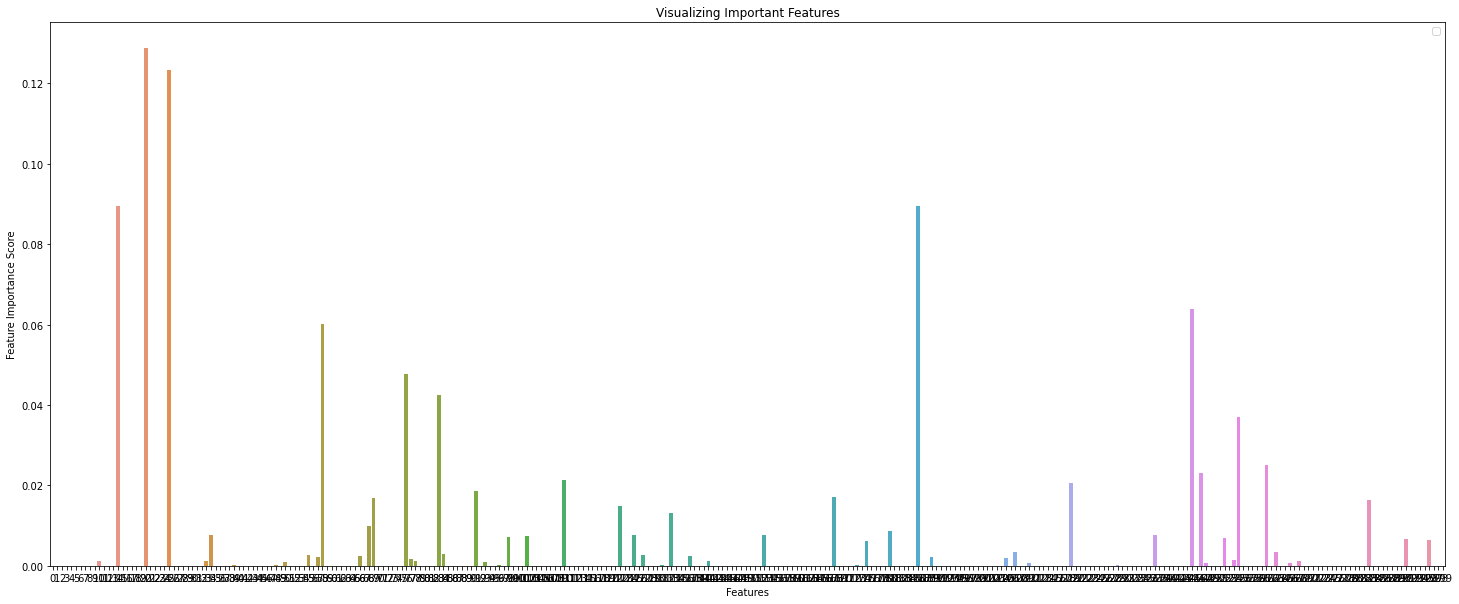

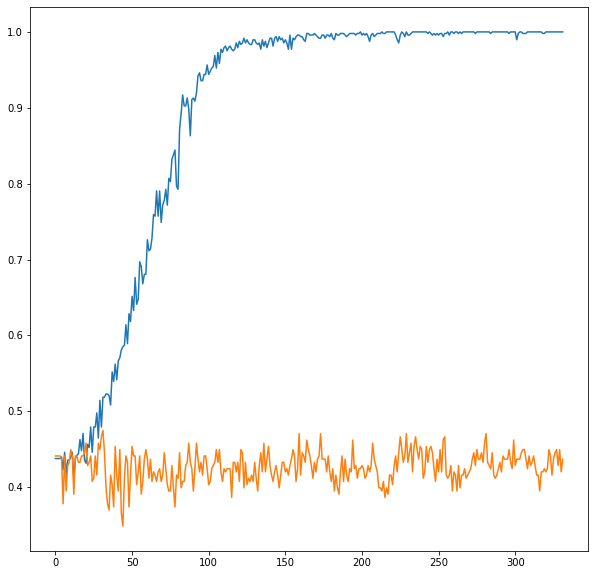

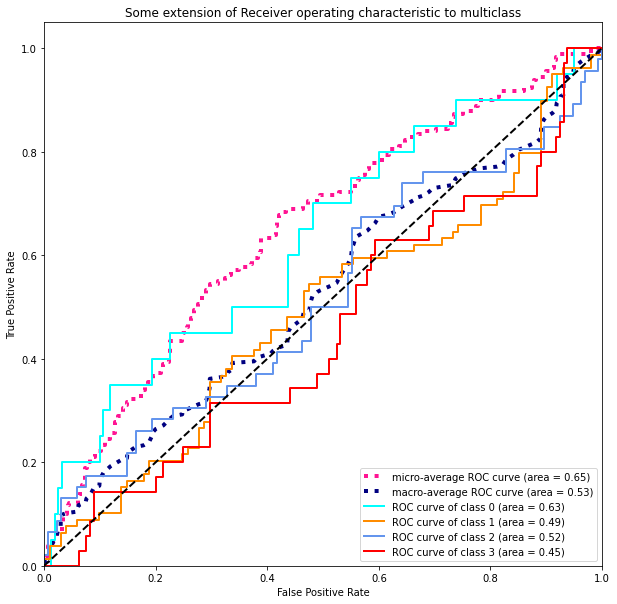

In [14]:
%matplotlib inline

X = z
features = pd.DataFrame(X)
feature_names = features.columns
print(feature_names)

labelspath = 'D:\Videos thesis\KN5jan7_annotated.csv'
labels = label_loader(labelspath)
y = labels

kf = StratifiedKFold(n_splits = 5, shuffle=True, random_state=420)

fold = 1
f1_scores = []
roc_auc_scores = []
accuracy_scores = []
for train, test in kf.split(X, y):
    print('Fold: #', fold)
    y_train = y[train]
    X_train = X[train]
    y_test = y[test]
    X_test = X[test]

    #X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.33, random_state = 1)

    #RandomForestClassifier stats
    rfclf=RandomForestClassifier()

    parameters1 = {
        'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, None],
        'max_features': ['auto', 'sqrt'],
        }


    clf = GridSearchCV(
        estimator=rfclf, 
        param_grid=parameters1,
        n_jobs=-1,
        scoring=['f1_weighted', 'accuracy'],
        refit='f1_weighted' 
    )

    clf.fit(X_train, y_train)

    y_pred1 = clf.predict(X_test)
    test_cm1 = confusion_matrix(y_test,y_pred1)
    test_report1 = classification_report(y_test,y_pred1)
    print('Best Params RFC:', clf.best_params_)
    print("Weighted F1 score RFC:",f1_score(y_test, y_pred1, average='weighted'))
    print("Accuracy RFC:",metrics.accuracy_score(y_test, y_pred1))
    print("Confusion matrix RFC:")
    print(test_cm1)
    print("Classification Report RFC:")
    print(test_report1)
    feature_imp1 = pd.Series(clf.best_estimator_.feature_importances_).sort_values(ascending=False)
    featureplot(feature_imp1)

    #AdaboostClassifier stats
    adb = AdaBoostClassifier(base_estimator=clf.best_estimator_) #, n_estimators=300, learning_rate=1
    
    parameters2 = {
    'n_estimators':[1, 5, 10, 20, 50, 100, 500, 1000, 2000],
    'learning_rate':[0.001, 0.01, 0.1, 1]
    }

    adbc = GridSearchCV(
        estimator=adb, 
        param_grid=parameters2,
        n_jobs=-1,
        scoring=['f1_weighted', 'accuracy'],
        refit='f1_weighted' 
    )

    adbc.fit(X_train,y_train)

    y_pred2 = adbc.predict(X_test)
    test_cm2 = confusion_matrix(y_test,y_pred2)
    test_report2 = classification_report(y_test,y_pred2)
    print('Best Params ADBC:', adbc.best_params_)
    print("Weighted F1 score ADBC:",f1_score(y_test, y_pred2, average='weighted'))
    print("Accuracy ADBC:",metrics.accuracy_score(y_test, y_pred2))
    print("Confusion matrix ADBC:")
    print(test_cm2)
    print("Classification Report ADBC:")
    print(test_report2)
    feature_imp2 = pd.Series(adbc.best_estimator_.feature_importances_).sort_values(ascending=False)
    featureplot(feature_imp2)

    #SVM Classifier stats
    svc = svm.SVC() 

    rfe = RFE(estimator=svc, step=1) #n_estimators = 10 for top 10 influential features

    parameters4 = {
        'estimator__kernel':['linear', 'rbf'],
        'estimator__C':[0.1, 1, 10, 50, 100],
        'estimator__gamma': [1, 0.1, 0.01],
        'n_features_to_select': [1, 10, 50, 100, 300]
        }
                   
    svcclf = GridSearchCV(
        estimator=rfe, 
        param_grid=parameters4,
        n_jobs=-1,
        scoring=['f1_weighted', 'accuracy'],
        refit='f1_weighted',
        return_train_score = True
    )
    #svcclf = svcclf.best_estimator_
    print("SVM is calculating....")
    svcclf.fit(X_train, y_train)
    #print(svcclf.cv_results_)


    #    print('Best Params:', svcclf.best_params_)
    #    print('Best Score:', svcclf.best_score_)
    #pd.Series(abs(svm.coef_[0]), index=features.columns).nlargest(10).plot(kind='barh')

    y_pred4 = svcclf.predict(X_test)
    test_cm4 = confusion_matrix(y_test,y_pred4)
    test_report4 = classification_report(y_test,y_pred4)
    if svcclf.best_params_['estimator__kernel'] == 'linear':
        svmfeatureplot(svcclf.cv_results_)
        svmfeatureimportance(svcclf.best_estimator_.estimator_.coef_, feature_names)

    if svcclf.best_params_['estimator__kernel'] == 'rbf':
        svmfeatureplot(svcclf.cv_results_)
        perm_importance = permutation_importance(svcclf.best_estimator_, X_test, y_test)
        svmrbfplot(perm_importance, feature_names)

    #    print('Coefficients:', svcclf.best_estimator_.estimator__.coef_)
    
    print('Best Params SVM:', svcclf.best_params_)
    print("Weighted F1 score SVM:",f1_score(y_test, y_pred4, average='weighted'))   #Might give F1 score warning for not predicting all classes
    print("Accuracy SVM:",metrics.accuracy_score(y_test, y_pred4))
    print("Confusion matrix SVM:")
    print(test_cm4)
    print("Classification Report SVM:")
    print(test_report4)
    #Make feature importance graph
    #feature_imp4 = pd.Series(svcclf.feature_importances_).sort_values(ascending=False)
    #featureplot(feature_imp4)

    #GradientBoostingClassifier stats
    gradbc = GradientBoostingClassifier()

    parameters3 = {
            #'n_estimators':[1, 50, 100, 500],
            'learning_rate':[0.001, 0.01, 0.1, 1]
    }
                   
    gbc = GridSearchCV(
        estimator=gradbc, 
        param_grid=parameters3,
        n_jobs=-1,
        scoring=['f1_weighted', 'accuracy'],
        refit='f1_weighted' 
    )    

    gbc.fit(X_train, y_train)

    y_pred3 = gbc.predict(X_test)
    test_cm3 = confusion_matrix(y_test,y_pred3)
    test_report3 = classification_report(y_test,y_pred3)
    print('Best Params GBC:', gbc.best_params_)
    print("Weighted F1 score GBC:",f1_score(y_test, y_pred3, average='weighted'))
    print("Accuracy GBC:",metrics.accuracy_score(y_test, y_pred3))
    print("Confusion matrix GBC:")
    print(test_cm3)
    print("Classification Report GBC:")
    print(test_report3)
    #Make feature importance graph
    feature_imp3 = pd.Series(gbc.best_estimator_.feature_importances_).sort_values(ascending=False)
    featureplot(feature_imp3)

    #Tabnet Classifier
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.33, random_state = 1)

    tabclf = TabNetClassifier(
        n_d=64, n_a=64, n_steps=1,
        gamma=1.2, n_independent=2, n_shared=2,
        cat_emb_dim=1,
        lambda_sparse=1e-4, momentum=0.3, clip_value=2.,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=2e-2),
        scheduler_params = {"gamma": 0.95,
                            "step_size": 10},
        scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15,
        seed = 1, verbose = 0
    )

    max_epochs = 1000

    h = tabclf.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        eval_name=['train', 'valid'],
        max_epochs=max_epochs, patience=300,
        batch_size=64, virtual_batch_size=32
    )
    
    y_pred = tabclf.predict(X_test)

    test_cm = confusion_matrix(y_test,y_pred)
    test_report = classification_report(y_test,y_pred)
    print("Weighted F1 score Tabnet:",f1_score(y_test, y_pred, average='weighted'))
    print()
    print("Accuracy Tabnet:",metrics.accuracy_score(y_test, y_pred))
    print()
    print("Confusion matrix Tabnet:")
    print(test_cm3)
    print()
    print("Classification Report Tabnet:")
    print(test_report3)
    #Make feature importance graph
    feature_imp = pd.Series(tabclf.feature_importances_).sort_values(ascending=False)
    featureplot(feature_imp)

    show_accuracy(tabclf.history['train_accuracy'], tabclf.history['valid_accuracy'])

    test_pred_proba = tabclf.predict_proba(X_test)
    y_test = label_binarize(y_test, classes=[0, 1, 2, 3])
    show_roc_plot(y_test, test_pred_proba, fold)


    #Fold Count
    fold = fold+1

In [8]:
#rfe.get_params().keys()
svcclf.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__estimator__C', 'estimator__estimator__break_ties', 'estimator__estimator__cache_size', 'estimator__estimator__class_weight', 'estimator__estimator__coef0', 'estimator__estimator__decision_function_shape', 'estimator__estimator__degree', 'estimator__estimator__gamma', 'estimator__estimator__kernel', 'estimator__estimator__max_iter', 'estimator__estimator__probability', 'estimator__estimator__random_state', 'estimator__estimator__shrinking', 'estimator__estimator__tol', 'estimator__estimator__verbose', 'estimator__estimator', 'estimator__importance_getter', 'estimator__n_features_to_select', 'estimator__step', 'estimator__verbose', 'estimator', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_train_score', 'scoring', 'verbose'])

Fold: # 1
Best Params RFC: {'max_depth': None, 'max_features': 'sqrt'}
Weighted F1 score RFC: 0.4773190576020764
Accuracy RFC: 0.5277777777777778
Confusion matrix RFC:
[[ 8 11  2  0]
 [ 0 70  6  3]
 [ 1 25 13  6]
 [ 0 27  4  4]]
Classification Report RFC:
              precision    recall  f1-score   support

           0       0.89      0.38      0.53        21
           1       0.53      0.89      0.66        79
           2       0.52      0.29      0.37        45
           3       0.31      0.11      0.17        35

    accuracy                           0.53       180
   macro avg       0.56      0.42      0.43       180
weighted avg       0.52      0.53      0.48       180



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


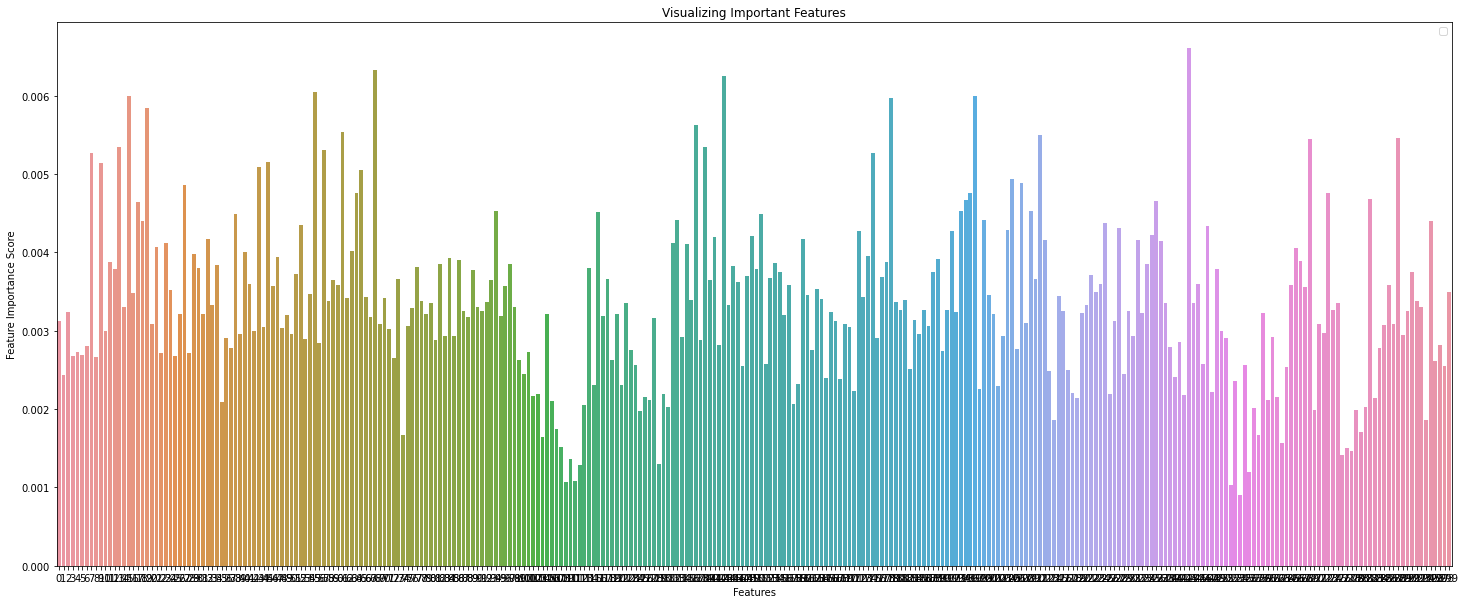

SVM is calculating....


KeyboardInterrupt: 

In [22]:
%matplotlib inline

X = z

labelspath = 'D:\Videos thesis\KN5jan7_annotated.csv'
labels = label_loader(labelspath)
y = labels

kf = StratifiedKFold(n_splits = 5, shuffle=True, random_state=420)

fold = 1
f1_scores = []
roc_auc_scores = []
accuracy_scores = []
for train, test in kf.split(X, y):
    print('Fold: #', fold)
    y_train = y[train]
    X_train = X[train]
    y_test = y[test]
    X_test = X[test]

    #RandomForestClassifier stats
    rfclf=RandomForestClassifier()

    parameters1 = {
        'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, None],
        'max_features': ['auto', 'sqrt'],
        }


    clf = GridSearchCV(
        estimator=rfclf, 
        param_grid=parameters1,
        n_jobs=-1,
        scoring=['f1_weighted', 'accuracy'],
        refit='f1_weighted' 
    )

    clf.fit(X_train, y_train)

    y_pred1 = clf.predict(X_test)
    test_cm1 = confusion_matrix(y_test,y_pred1)
    test_report1 = classification_report(y_test,y_pred1)
    print('Best Params RFC:', clf.best_params_)
    print("Weighted F1 score RFC:",f1_score(y_test, y_pred1, average='weighted'))
    print("Accuracy RFC:",metrics.accuracy_score(y_test, y_pred1))
    print("Confusion matrix RFC:")
    print(test_cm1)
    print("Classification Report RFC:")
    print(test_report1)
    feature_imp1 = pd.Series(clf.best_estimator_.feature_importances_).sort_values(ascending=False)
    featureplot(feature_imp1)

    #SVM Classifier stats
    svc = svm.SVC() 

    rfe = RFE(estimator=svc, step=1) #n_estimators = 10 for top 10 influential features

    parameters4 = {
        'estimator__kernel':['linear', 'rbf'],
        'estimator__C':[0.1, 1, 10, 20, 50, 100, 1000],
        'estimator__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
        'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,14,15,16,17,18,19,20],
        }
                   
    svcclf = GridSearchCV(
        estimator=rfe, 
        param_grid=parameters4,
        n_jobs=-1,
        scoring=['f1_weighted', 'accuracy'],
        refit='f1_weighted' 
    )
    #svcclf = svcclf.best_estimator_
    print("SVM is calculating....")
    svcclf.fit(X_train, y_train)
    #print(svcclf.cv_results_)


    #    print('Best Params:', svcclf.best_params_)
    #    print('Best Score:', svcclf.best_score_)
    #pd.Series(abs(svm.coef_[0]), index=features.columns).nlargest(10).plot(kind='barh')

    y_pred4 = svcclf.predict(X_test)
    test_cm4 = confusion_matrix(y_test,y_pred4)
    test_report4 = classification_report(y_test,y_pred4)
    if svcclf.best_params_['estimator__kernel'] == 'linear':
        svmfeatureplot(svcclf.cv_results_)
        svmfeatureimportance(svcclf.estimator_.coef_,feature_names)

    if svcclf.best_params_['estimator__kernel'] == 'rbf':
        svmfeatureplot(svcclf.cv_results_)
        perm_importance = permutation_importance(svcclf.best_params_, X_test, y_test)
        svmrbfplot(perm_importance, feature_names)

    #    print('Coefficients:', svcclf.best_estimator_.estimator__.coef_)
    
    print('Best Params SVM:', svcclf.best_params_)
    print("Weighted F1 score SVM:",f1_score(y_test, y_pred4, average='weighted'))   #Might give F1 score warning for not predicting all classes
    print("Accuracy SVM:",metrics.accuracy_score(y_test, y_pred4))
    print("Confusion matrix SVM:")
    print(test_cm4)
    print("Classification Report SVM:")
    print(test_report4)
    #Fold Count
    fold = fold+1


In [5]:
#Tabnet Classifier

#Recursive Feature Elimination (sklearn) with crossval to select nr of features
X = X

y = np.array(labels)
y = y.squeeze()

#originally from https://github.com/aryaprabawa/Startup-Invest-Prediction/blob/master/Predict_Investment_With_AUs.ipynb 
kf = StratifiedKFold(n_splits = 5, shuffle=True, random_state=420)

fold = 1
f1_scores = []
roc_auc_scores = []
accuracy_scores = []
for train, test in kf.split(X, y):
    print('Fold: #', fold)
    y_train = y[train]
    X_train = X[train]
    y_test = y[test]
    X_test = X[test]

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.33, random_state = 1)

    clf = TabNetClassifier(
        n_d=64, n_a=64, n_steps=2,
        gamma=1.2, n_independent=2, n_shared=2,
        cat_emb_dim=1,
        lambda_sparse=1e-4, momentum=0.3, clip_value=2.,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=2e-2),
        scheduler_params = {"gamma": 0.95,
                            "step_size": 10},
        scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15,
        seed = 1, verbose = 0
    )

    max_epochs = 1000

    h = clf.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        eval_name=['train', 'valid'],
        max_epochs=max_epochs, patience=300,
        batch_size=64, virtual_batch_size=32
    )
    
    y_pred = clf.predict(X_test)

    test_cm = confusion_matrix(y_test,y_pred)
    test_report = classification_report(y_test,y_pred)
    print("Weighted F1 score Tabnet:",f1_score(y_test, y_pred, average='weighted'))
    print()
    print("Accuracy Tabnet:",metrics.accuracy_score(y_test, y_pred))
    print()
    print("Confusion matrix Tabnet:")
    print(test_cm3)
    print()
    print("Classification Report Tabnet:")
    print(test_report3)
    #Make feature importance graph
    feature_imp = pd.Series(clf.feature_importances_).sort_values(ascending=False)
    featureplot(feature_imp)

    show_accuracy(clf.history['train_accuracy'], clf.history['valid_accuracy'])

    test_pred_proba = clf.predict_proba(X_test)
    y_test = label_binarize(y_test, classes=[0, 1, 2, 3])
    show_roc_plot(y_test, test_pred_proba, fold)
    fold = fold + 1

NameError: name 'X' is not defined